In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import btk

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, TensorDataset, DataLoader

from torch.utils.data import Subset

/lustre/fswork/projects/rech/tkc/commun/venv/a100/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os

# Add the path to the 'scripts' directory
scripts_path = os.path.abspath('../scripts')
sys.path.append(scripts_path)

from vae.model import VAE

from vae.dataset import SimpleBlendDataset , denormalize_non_linear , log_denorm
from vae.utils import train_epoch, val_epoch, save_checkpoint, load_checkpoint

### Read Dataset

In [3]:
# Create dataset
SCRATCH = os.getenv("ALL_CCFRSCRATCH")  
train_path = os.path.join(SCRATCH, "deblending/isolated/isolated_training_9_arcs")
dataset = SimpleBlendDataset(base_path=train_path, num_files=200, augment=True, beta=2.5)

Average max per band (used for normalization): [  181.5379713   2291.64356811  8914.07236348 10365.74202139
  8500.91897507  4870.23670412]


In [4]:
# Check some samples
print(f"Total samples: {len(dataset)}")
image, attrs = dataset[0]  # First sample
print(f"Image shape: {image.shape}")  # Should be [6, 45, 45]
print(f"Attributes: {attrs}")  # [redshift, e1, e2, r_ab]

Total samples: 200000
Image shape: torch.Size([6, 45, 45])
Attributes: tensor([ 1.8098,  0.0860, -0.0310, 22.9660])


### Dataset distribution

In [9]:
# Initialize lists to store attributes
redshifts = []
e = []
r_abs = []

# Collect data from the first few batches (enough for good statistics)
num_samples_to_plot = 1000  # Adjust as needed
for i in range(num_samples_to_plot):
    _, attrs = dataset[i]
    z, e1, e2, r = attrs.numpy()
    
    redshifts.append(z)
    e.append(np.sqrt(e1**2 + e2**2))
    r_abs.append(r)

# Convert to numpy arrays
redshifts = np.array(redshifts)
g = np.array(g)
e = np.array(e)
r_abs = np.array(r_abs)

KeyboardInterrupt: 

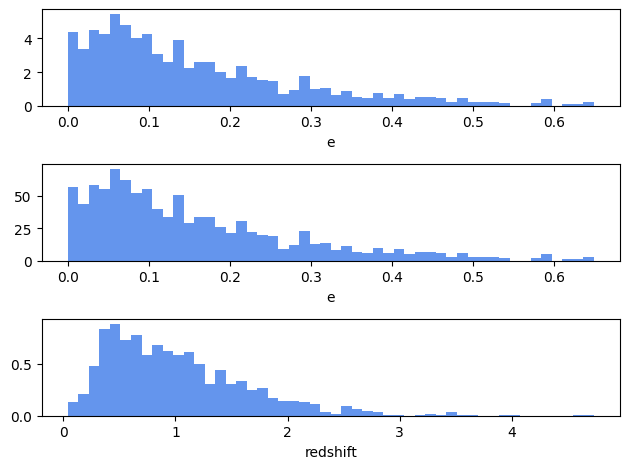

In [81]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.hist(e, bins=50, density=True, color="cornflowerblue")
ax1.set_xlabel("e")

ax2.hist(e, bins=50, color="cornflowerblue")
ax2.set_xlabel("e")

ax3.hist(redshifts, bins=50, density=True, color="cornflowerblue")
ax3.set_xlabel("redshift")

plt.tight_layout()
plt.show()

### Conditions for e

### Extract ellipticity

In [ ]:
e = np.empty(len(dataset))
e1 = np.empty(len(dataset))
e2 = np.empty(len(dataset))
for idx in range(len(dataset)):
    _, attrs = dataset[idx]  
    e1[idx] = attrs[1]  
    e2[idx] = attrs[2]
    e[idx] = np.sqrt(e1[idx]**2 + e2[idx]**2)

In [2]:
np.save("e_values.npy", e)
np.save("e1_values.npy", e1)
np.save("e2_values.npy", e2)

NameError: name 'np' is not defined

### Load ellipticity

In [5]:
e = np.load("../scripts/e_values.npy")

index = np.where(e > 0.1)[0]
fdataset = Subset(dataset, index)

### Visualization of dataset

In [27]:
def plot_figures(normalized=True):
    fig, ax = plt.subplots(5,5, figsize=(15,15))

    for i in range(5):
        for j in range(5):
            image, attrs = fdataset[5*i + j]
            if normalized:
                ax[i,j].imshow(image[2])
            else:
                denorm = denormalize_non_linear(image , dataset.avg_max_vals)
                ax[i,j].imshow(denorm[2])  # Updated to use denorm instead of image[0, 5]
            ax[i,j].axis("off")
            e_ = np.sqrt(attrs[1]**2 + attrs[2]**2)
            ax[i,j].set_title(f"e1 = {attrs[1]:.2f} | e2 = {attrs[2]:.2f} | e = {e_:.2f}")

    plt.tight_layout()
    plt.show()
    plt.close()

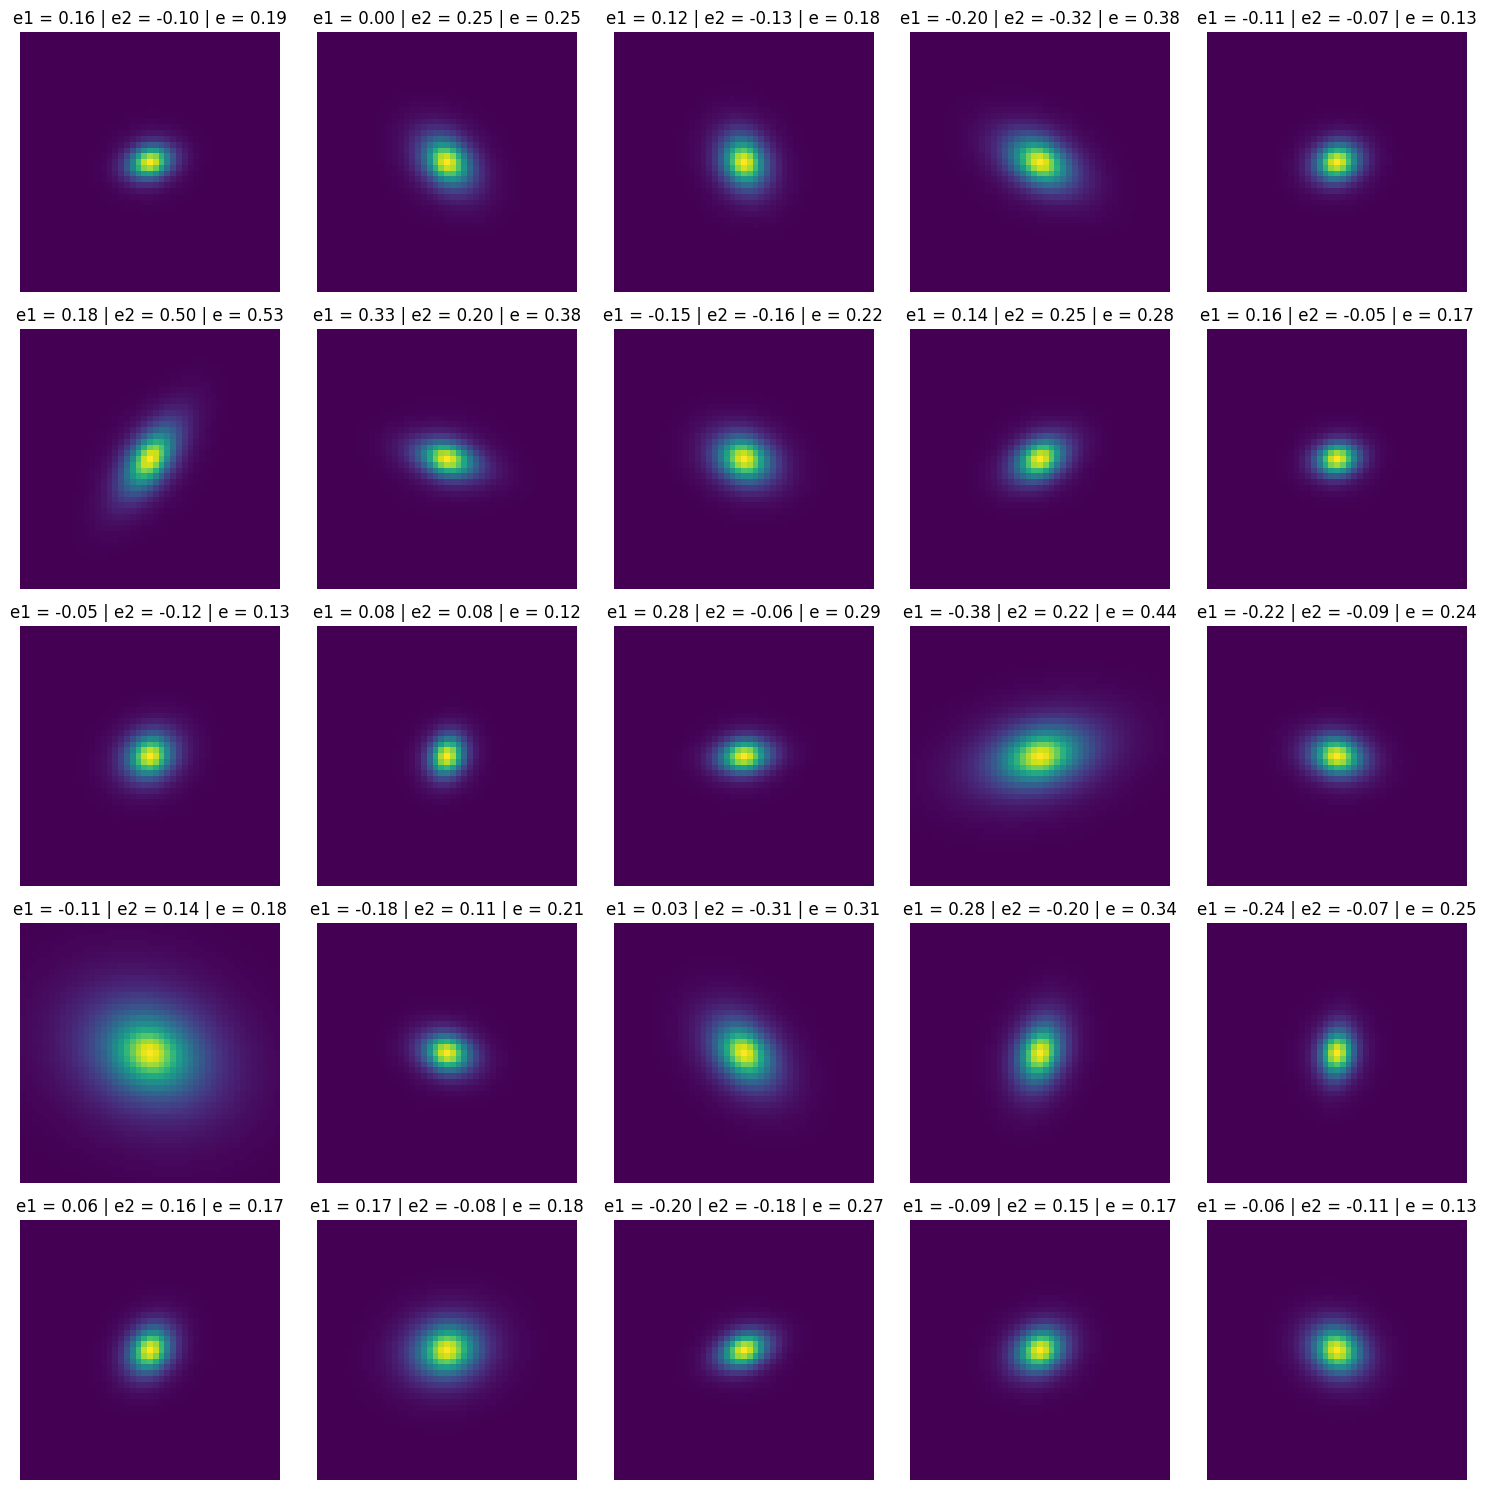

In [10]:
plot_figures(normalized=False)

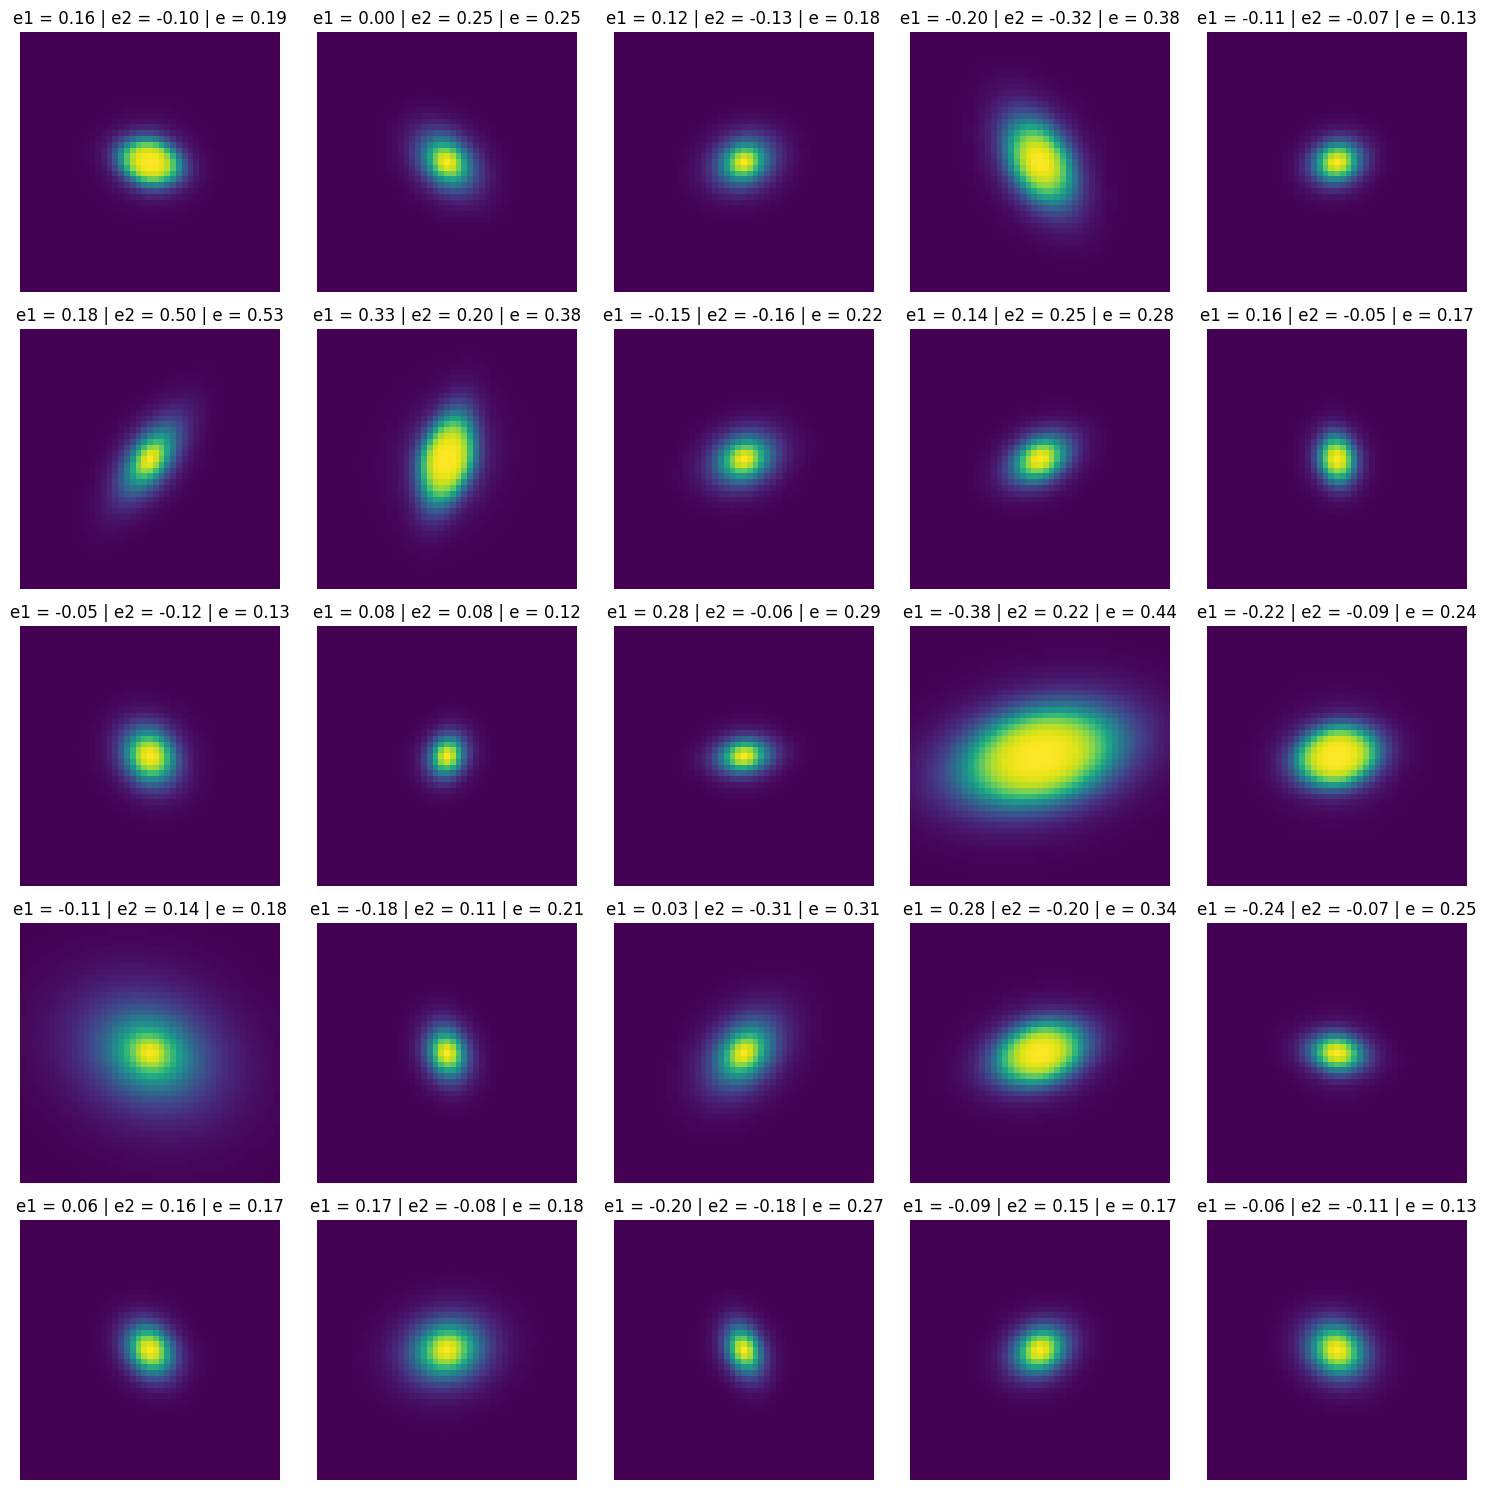

In [11]:
plot_figures(normalized=True)

## VAE

### Data loader

In [9]:
train_size = int(0.9 * len(fdataset))
val_size = len(fdataset) - train_size
generator = torch.Generator().manual_seed(42)  
train_dataset, val_dataset = random_split(fdataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    num_workers=8, # Parallel loading
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=8,
    pin_memory=True if torch.cuda.is_available() else False
)

### Device

In [10]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Training

In [31]:
# --- Initialize Model ---
torch.manual_seed(42)
latent_dims = 32
vae = VAE(latent_dim=latent_dims, beta = 1e-3)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)

vae.to(device)

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=1)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): PReLU(num_parameters=1)
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): PReLU(num_parameters=1)
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): PReLU(num_parameters=1)
      (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): PReLU(num_parameters=1)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (11): PReLU(num_parameters=1)
      (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): PReLU(num_parameters=1)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (15): PReLU(num_parameters=1)
      (16): Flatten(start_dim=1, end_dim=

In [32]:
def train_epoch(vae, device, dataloader, optimizer):
    vae.train()
    total_loss, total_mse, total_kl = 0.0, 0.0, 0.0

    for x, _ in dataloader:
        x = x.to(device)

        x_hat, mu, logvar = vae(x)
        loss_dict = vae.loss_function(x, x_hat, mu, logvar)

        optimizer.zero_grad()
        loss_dict['loss'].backward()
        optimizer.step()

        total_loss += loss_dict['loss'].item()
        total_mse += loss_dict['reconstruction_loss'].item()
        total_kl += loss_dict['kl_divergence'].item()

    n = len(dataloader.dataset)
    return total_loss / n, total_mse / n, total_kl / n


def test_epoch(vae, device, dataloader):
    vae.eval()
    total_loss, total_mse, total_kl = 0.0, 0.0, 0.0
    plotted = 0

    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)

            x_hat, mu, logvar = vae(x)
            loss_dict = vae.loss_function(x, x_hat, mu, logvar)

            total_loss += loss_dict['loss'].item()
            total_mse += loss_dict['reconstruction_loss'].item()
            total_kl += loss_dict['kl_divergence'].item()

            # Plot 3 random reconstructions from this batch
            if plotted < 3:
                fig, axs = plt.subplots(1, 2, figsize=(6, 3))
                i = np.random.randint(0, x.shape[0])
                orig = denormalize_non_linear(x[i].cpu().numpy() , dataset.avg_max_vals)
                recon = denormalize_non_linear(x_hat[i].cpu().numpy() , dataset.avg_max_vals)
                mse = np.mean((recon - orig) ** 2)
                mae = np.mean(np.abs(recon - orig))

                axs[0].imshow(orig[4], cmap="viridis")
                axs[0].set_title("Original")
                axs[0].axis("off")

                axs[1].imshow(recon[4], cmap="viridis")
                axs[1].set_title(f"Recon\nMSE:{mse:.2e}\nMAE:{mae:.2e}")
                axs[1].axis("off")

                plt.tight_layout()
                plt.show()

                plotted += 1

    n = len(dataloader.dataset)
    return total_loss / n, total_mse / n, total_kl / n


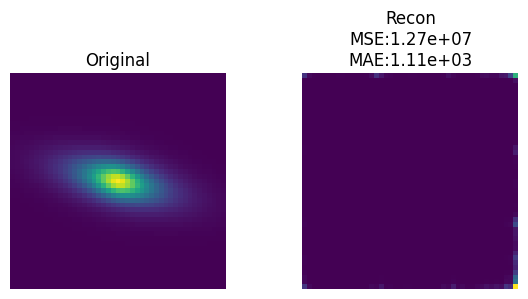

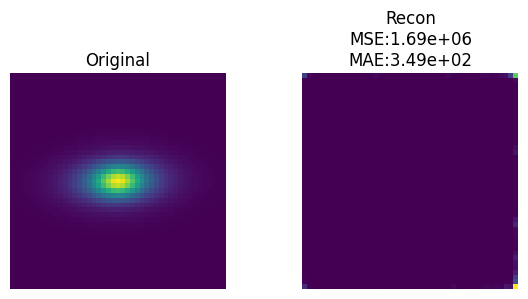

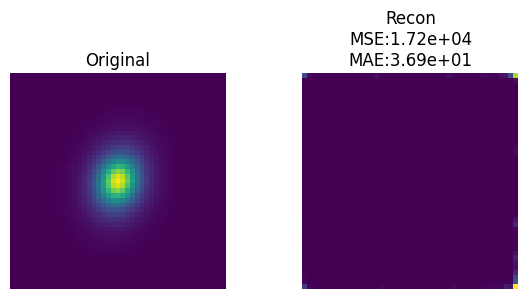


EPOCH 1/30
Train Loss: 5.390e-04 | MSE: 5.272e-04 | KL: 1.178e-02
Val   Loss: 2.953e-04 | MSE: 2.952e-04 | KL: 4.271e-05


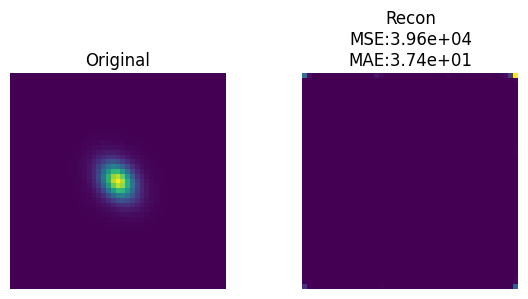

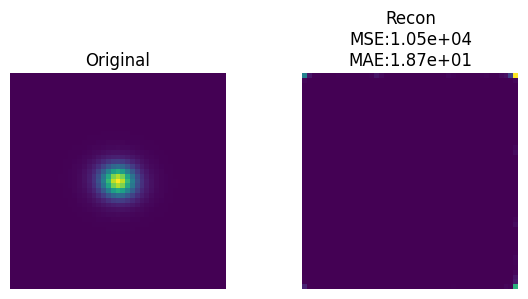

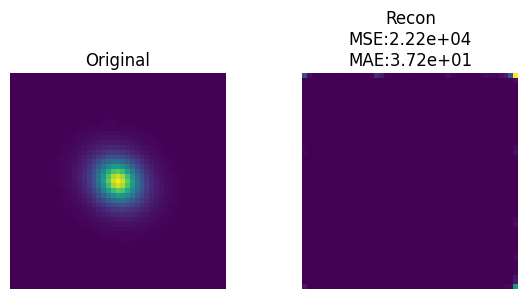


EPOCH 2/30
Train Loss: 3.008e-04 | MSE: 3.008e-04 | KL: 1.467e-05
Val   Loss: 2.947e-04 | MSE: 2.947e-04 | KL: 7.121e-06


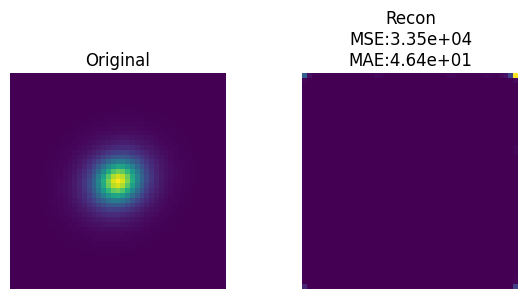

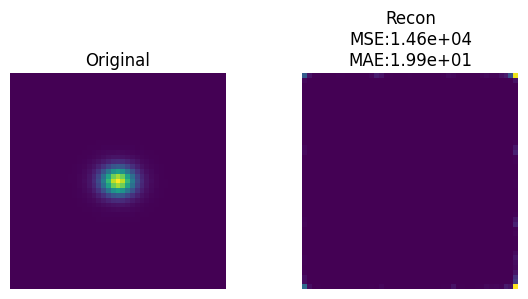

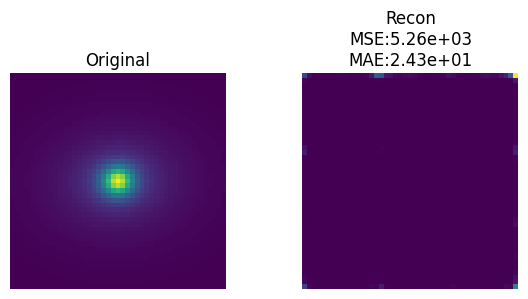


EPOCH 3/30
Train Loss: 3.005e-04 | MSE: 3.004e-04 | KL: 5.025e-06
Val   Loss: 2.946e-04 | MSE: 2.946e-04 | KL: 3.363e-06


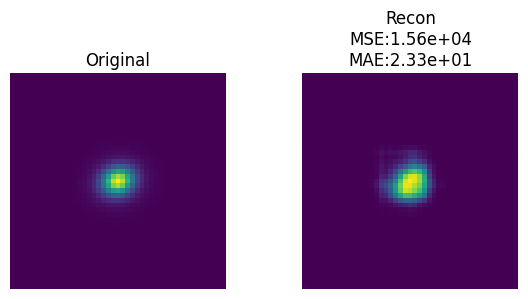

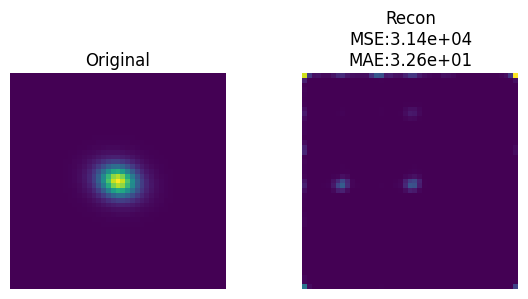

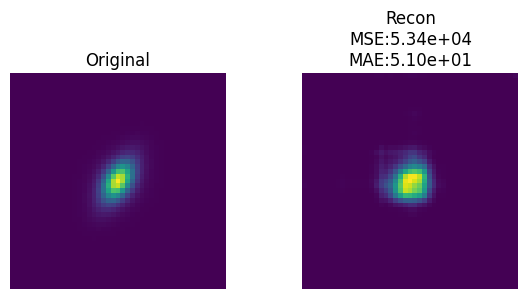


EPOCH 4/30
Train Loss: 2.961e-04 | MSE: 2.950e-04 | KL: 1.113e-03
Val   Loss: 1.967e-04 | MSE: 1.770e-04 | KL: 1.969e-02


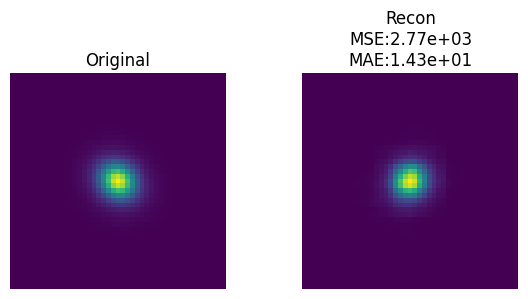

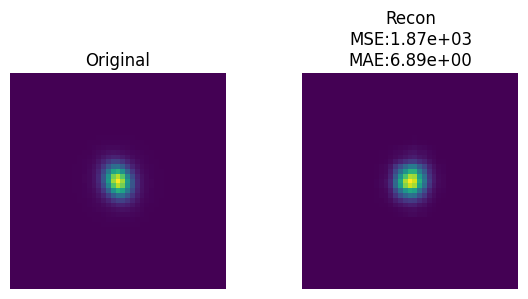

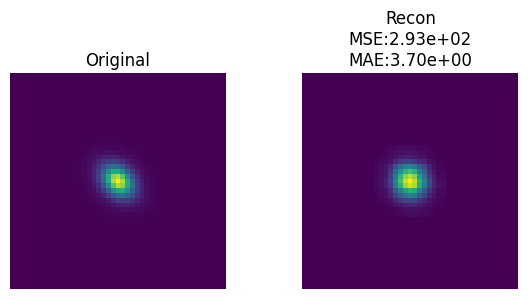


EPOCH 5/30
Train Loss: 1.448e-04 | MSE: 1.276e-04 | KL: 1.713e-02
Val   Loss: 1.221e-04 | MSE: 1.052e-04 | KL: 1.693e-02


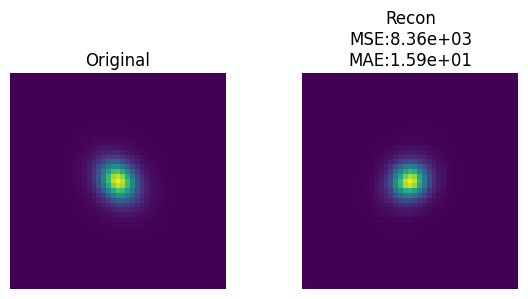

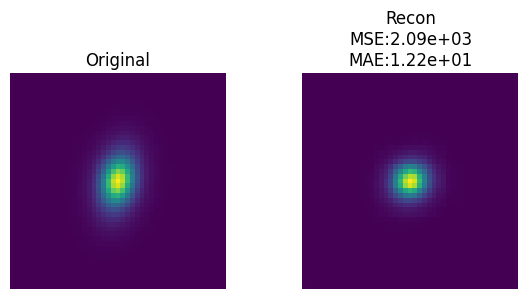

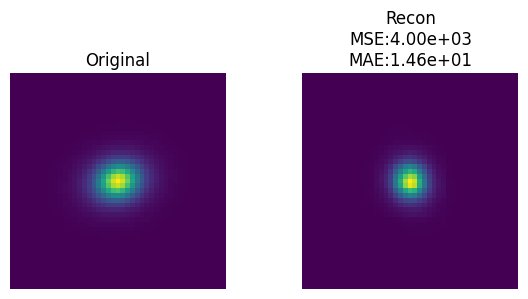


EPOCH 6/30
Train Loss: 1.194e-04 | MSE: 1.004e-04 | KL: 1.905e-02
Val   Loss: 1.142e-04 | MSE: 9.511e-05 | KL: 1.904e-02


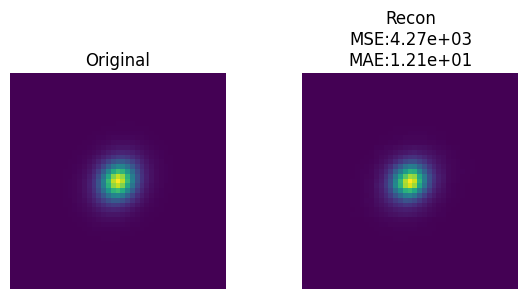

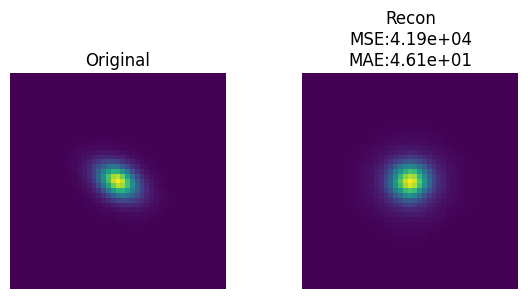

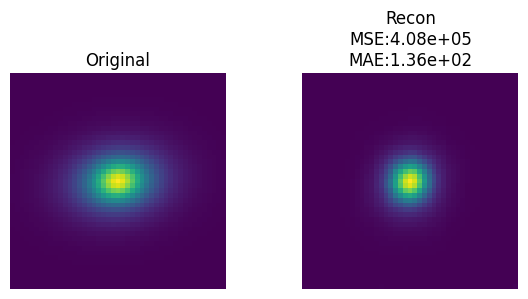


EPOCH 7/30
Train Loss: 1.139e-04 | MSE: 9.447e-05 | KL: 1.943e-02
Val   Loss: 1.110e-04 | MSE: 9.168e-05 | KL: 1.931e-02


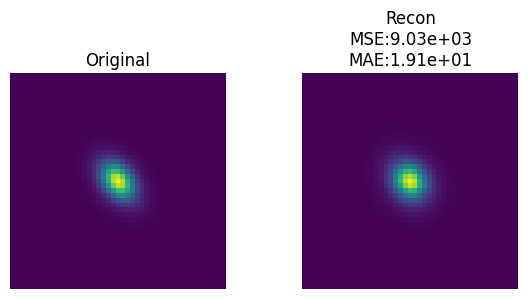

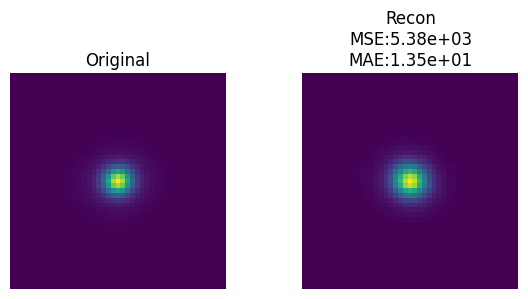

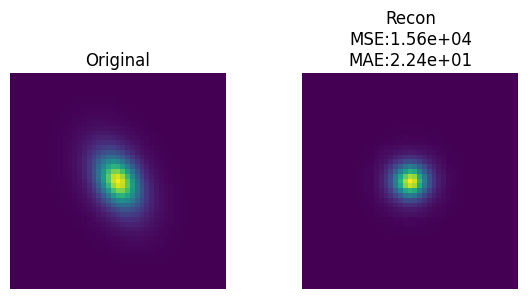


EPOCH 8/30
Train Loss: 1.115e-04 | MSE: 9.187e-05 | KL: 1.960e-02
Val   Loss: 1.101e-04 | MSE: 9.158e-05 | KL: 1.850e-02


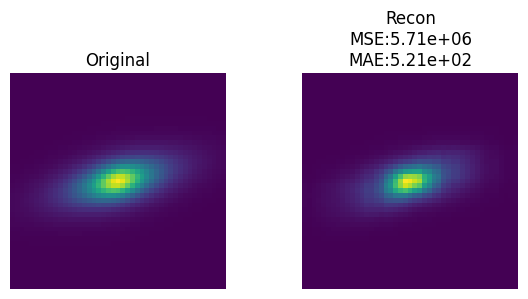

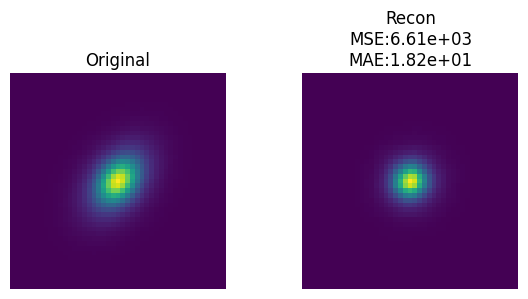

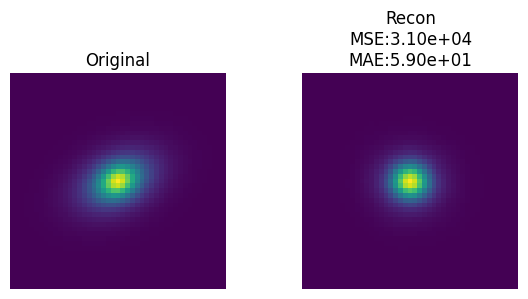


EPOCH 9/30
Train Loss: 1.100e-04 | MSE: 9.016e-05 | KL: 1.986e-02
Val   Loss: 1.079e-04 | MSE: 8.780e-05 | KL: 2.010e-02


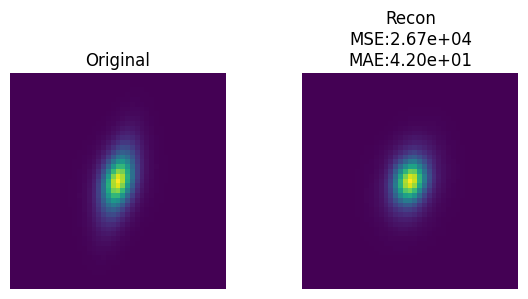

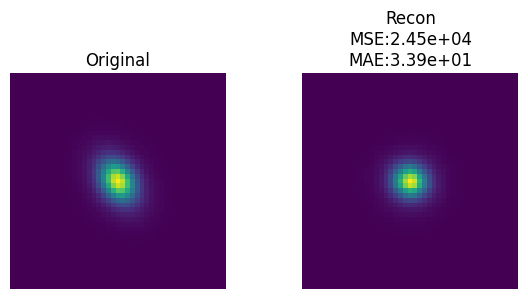

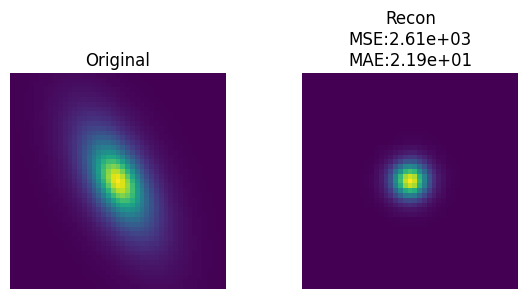


EPOCH 10/30
Train Loss: 1.088e-04 | MSE: 8.844e-05 | KL: 2.036e-02
Val   Loss: 1.072e-04 | MSE: 8.668e-05 | KL: 2.052e-02
Checkpoint saved at epoch 10


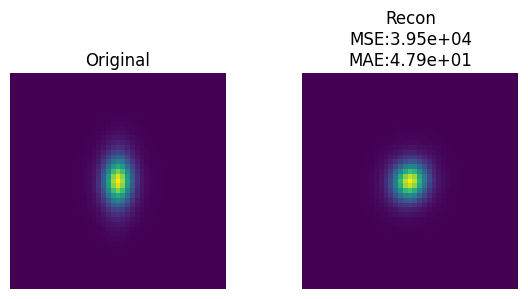

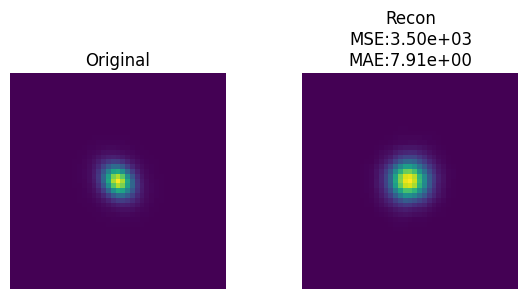

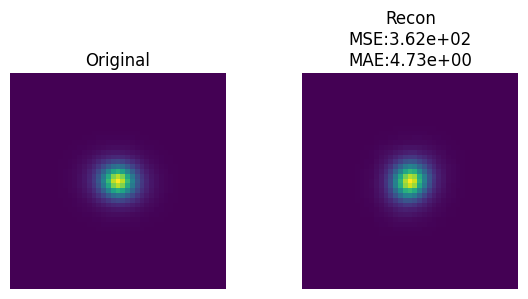


EPOCH 11/30
Train Loss: 1.078e-04 | MSE: 8.702e-05 | KL: 2.077e-02
Val   Loss: 1.064e-04 | MSE: 8.686e-05 | KL: 1.957e-02


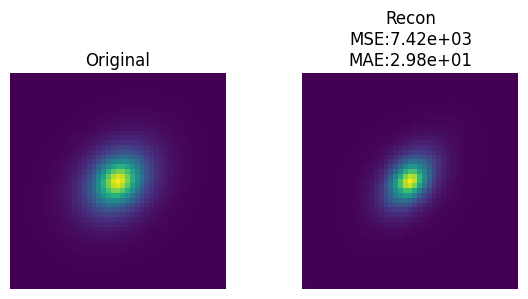

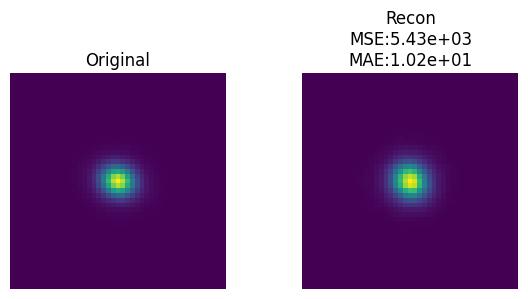

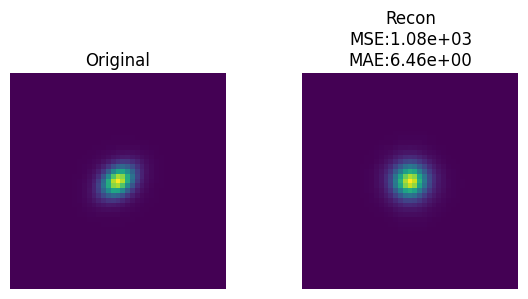


EPOCH 12/30
Train Loss: 1.071e-04 | MSE: 8.626e-05 | KL: 2.083e-02
Val   Loss: 1.056e-04 | MSE: 8.530e-05 | KL: 2.031e-02


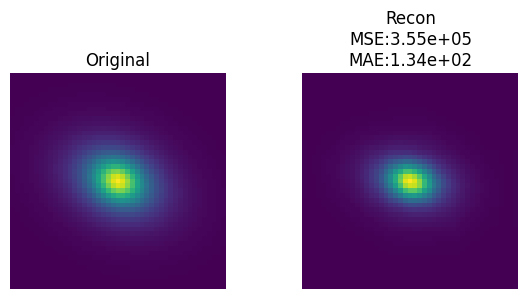

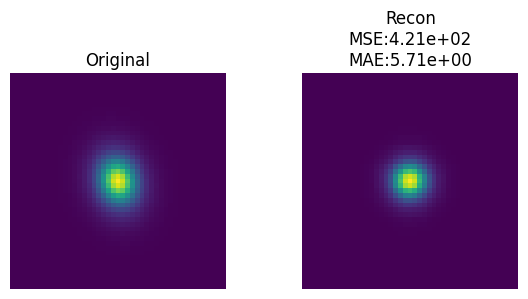

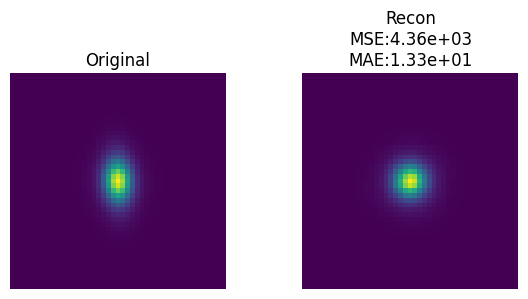


EPOCH 13/30
Train Loss: 1.062e-04 | MSE: 8.513e-05 | KL: 2.106e-02
Val   Loss: 1.042e-04 | MSE: 8.379e-05 | KL: 2.037e-02


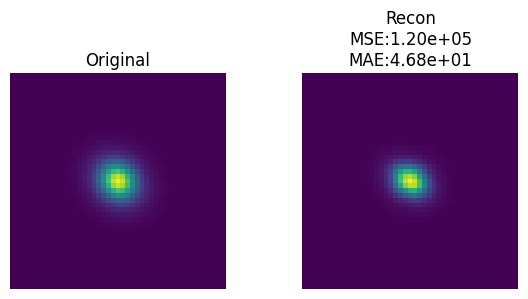

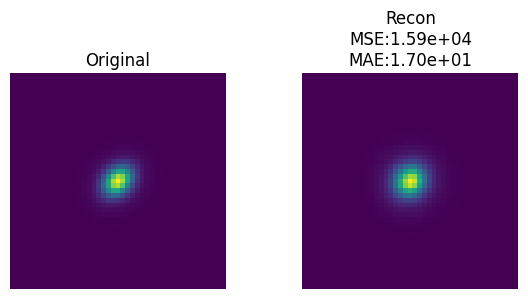

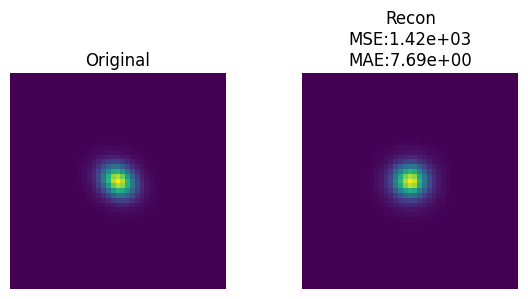


EPOCH 14/30
Train Loss: 1.051e-04 | MSE: 8.339e-05 | KL: 2.168e-02
Val   Loss: 1.026e-04 | MSE: 8.043e-05 | KL: 2.214e-02


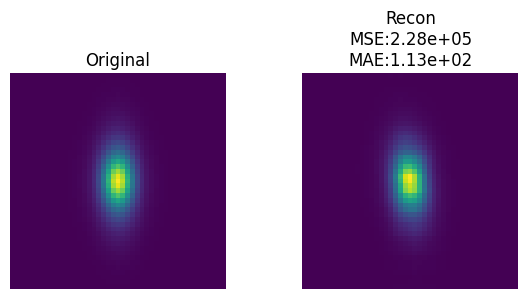

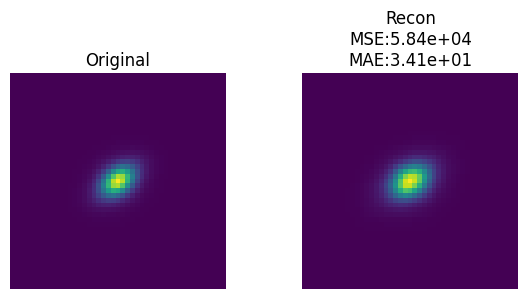

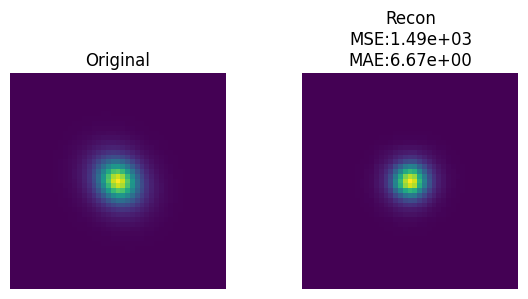


EPOCH 15/30
Train Loss: 9.946e-05 | MSE: 7.409e-05 | KL: 2.537e-02
Val   Loss: 9.509e-05 | MSE: 6.902e-05 | KL: 2.607e-02


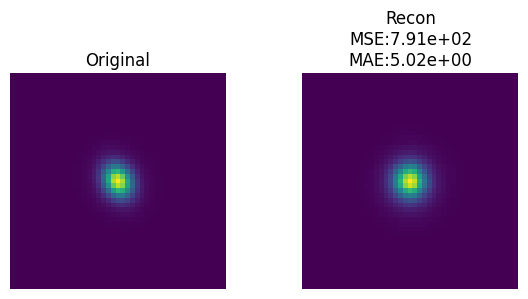

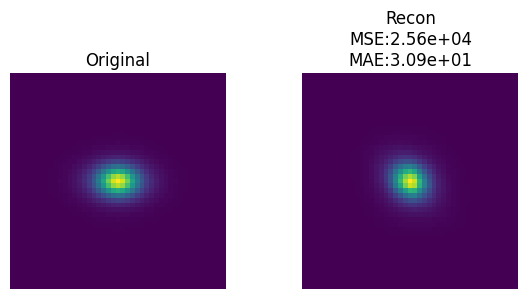

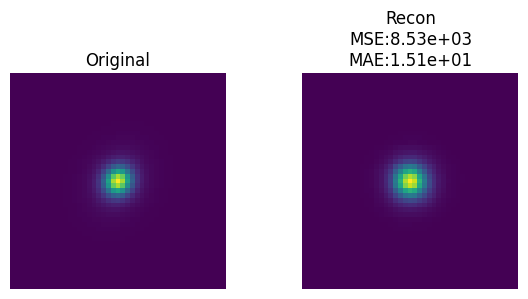


EPOCH 16/30
Train Loss: 9.325e-05 | MSE: 6.563e-05 | KL: 2.761e-02
Val   Loss: 9.142e-05 | MSE: 6.367e-05 | KL: 2.775e-02


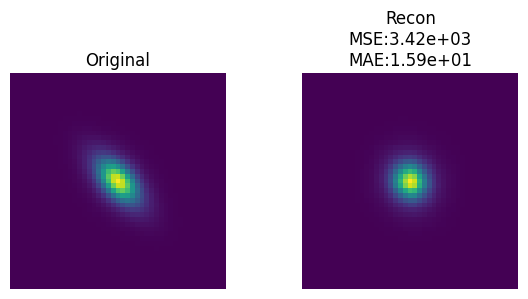

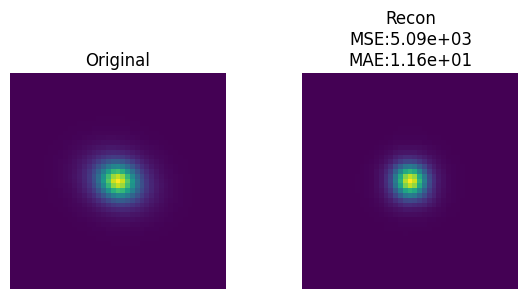

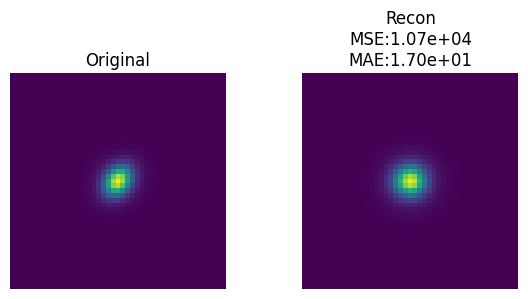


EPOCH 17/30
Train Loss: 9.162e-05 | MSE: 6.339e-05 | KL: 2.823e-02
Val   Loss: 9.025e-05 | MSE: 6.261e-05 | KL: 2.764e-02


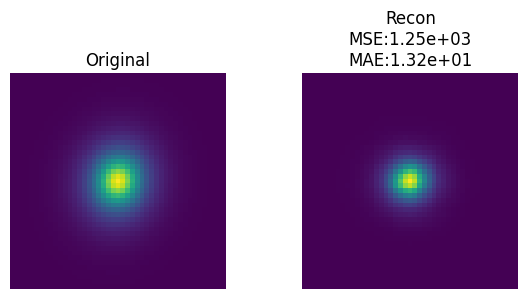

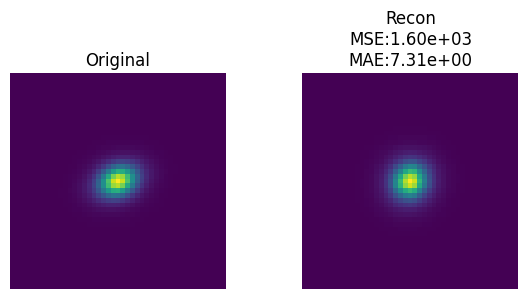

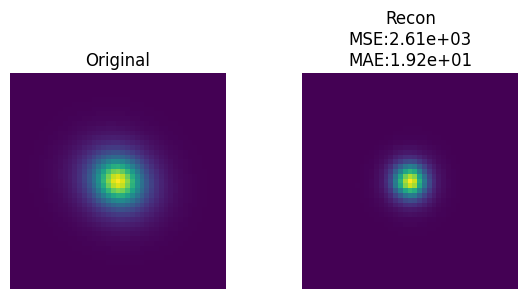


EPOCH 18/30
Train Loss: 9.086e-05 | MSE: 6.235e-05 | KL: 2.851e-02
Val   Loss: 8.963e-05 | MSE: 6.081e-05 | KL: 2.882e-02


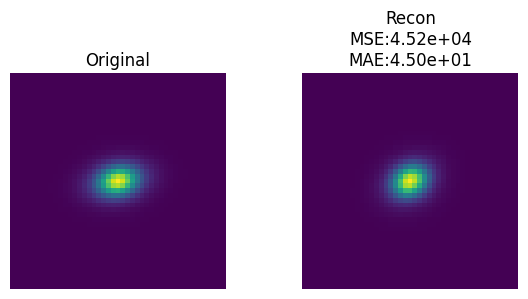

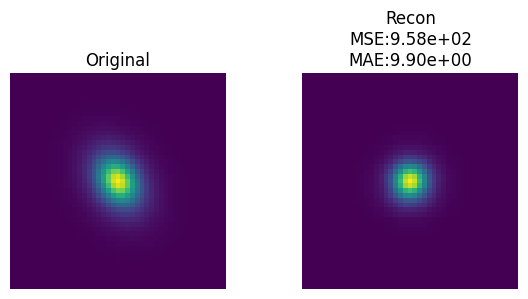

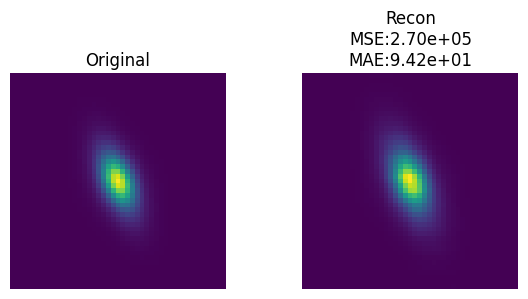


EPOCH 19/30
Train Loss: 8.971e-05 | MSE: 6.019e-05 | KL: 2.953e-02
Val   Loss: 9.021e-05 | MSE: 6.209e-05 | KL: 2.811e-02


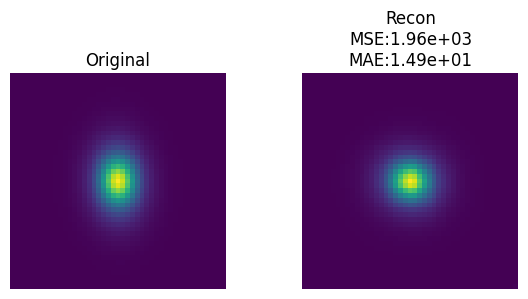

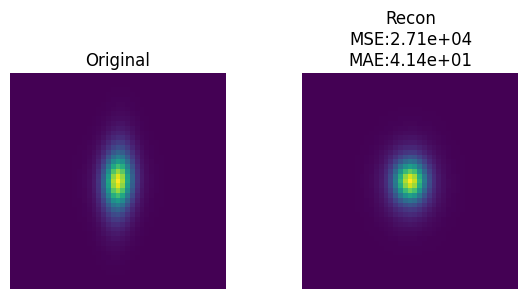

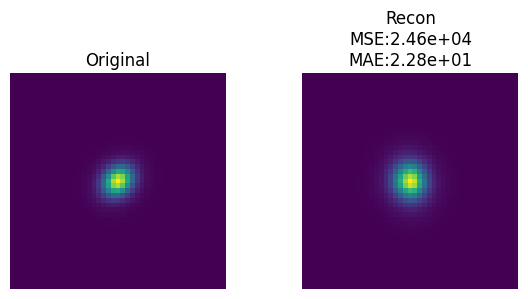


EPOCH 20/30
Train Loss: 8.911e-05 | MSE: 5.902e-05 | KL: 3.009e-02
Val   Loss: 8.834e-05 | MSE: 5.854e-05 | KL: 2.980e-02
Checkpoint saved at epoch 20


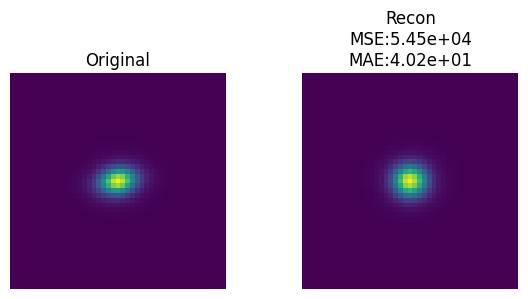

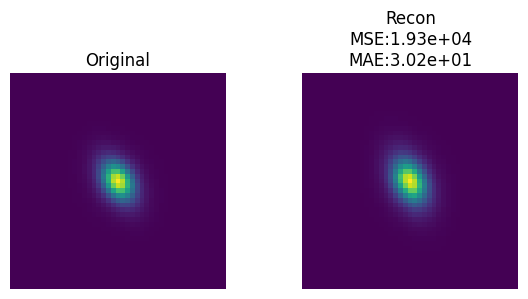

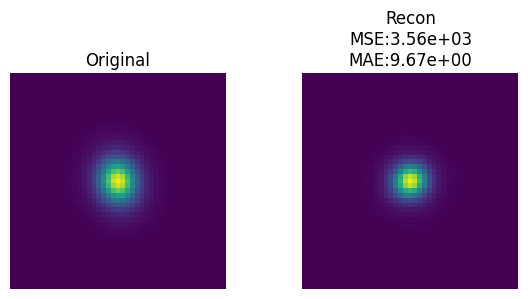


EPOCH 21/30
Train Loss: 8.850e-05 | MSE: 5.815e-05 | KL: 3.035e-02
Val   Loss: 8.745e-05 | MSE: 5.666e-05 | KL: 3.079e-02


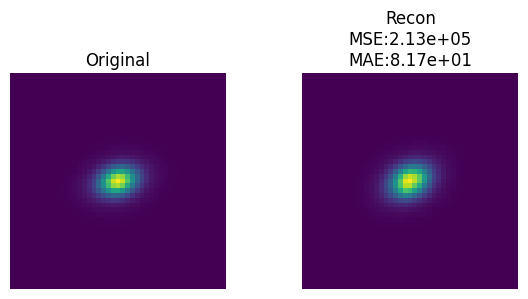

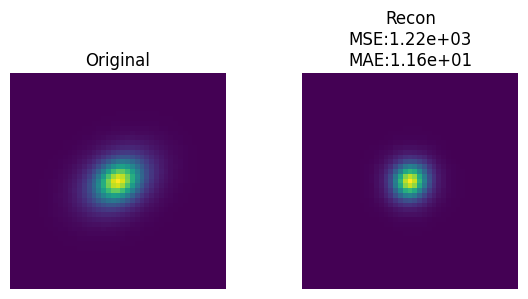

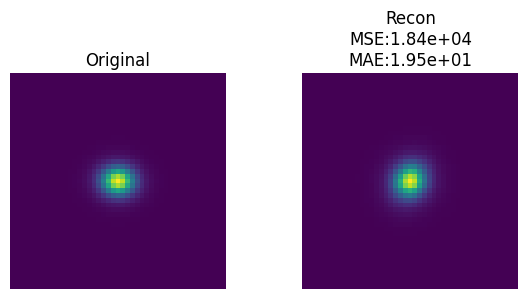


EPOCH 22/30
Train Loss: 8.813e-05 | MSE: 5.740e-05 | KL: 3.073e-02
Val   Loss: 8.757e-05 | MSE: 5.733e-05 | KL: 3.024e-02


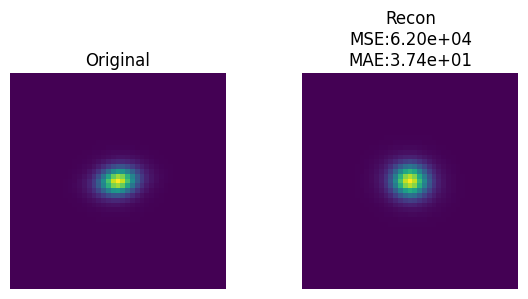

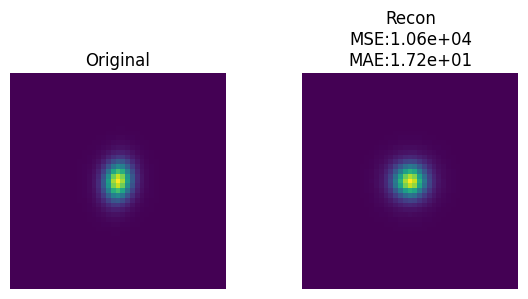

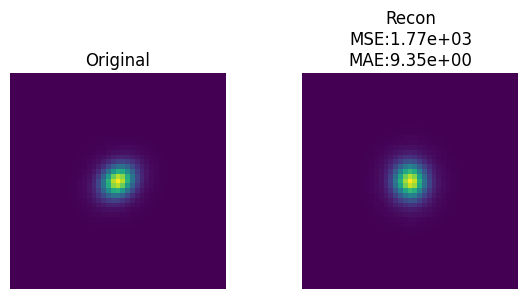


EPOCH 23/30
Train Loss: 8.793e-05 | MSE: 5.726e-05 | KL: 3.066e-02
Val   Loss: 8.698e-05 | MSE: 5.661e-05 | KL: 3.037e-02


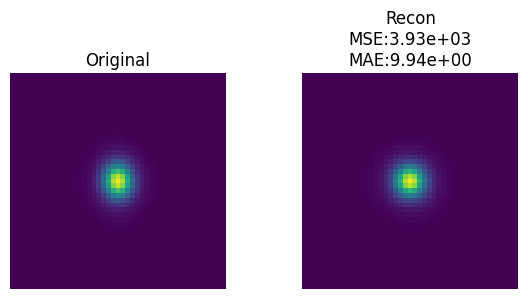

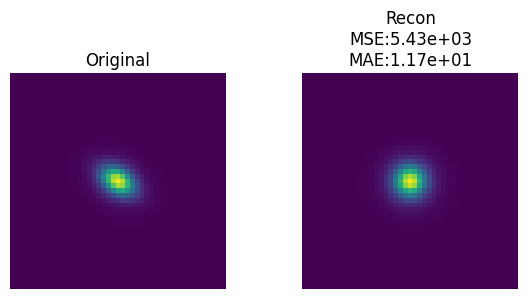

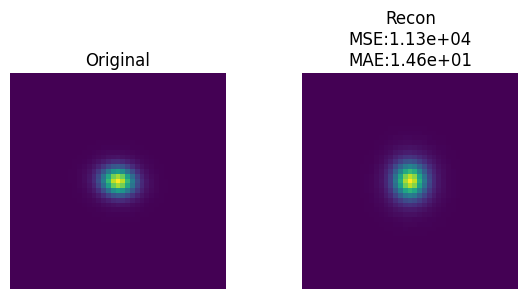


EPOCH 24/30
Train Loss: 8.751e-05 | MSE: 5.670e-05 | KL: 3.081e-02
Val   Loss: 8.600e-05 | MSE: 5.510e-05 | KL: 3.090e-02


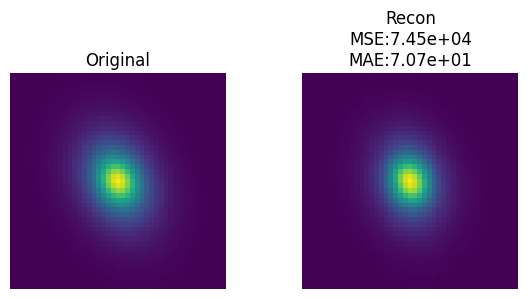

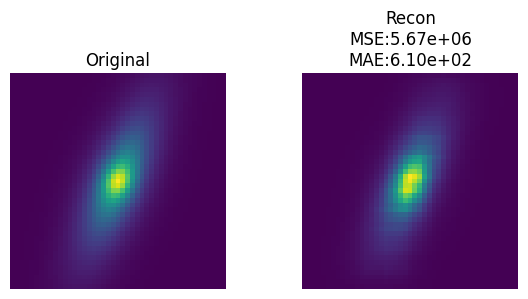

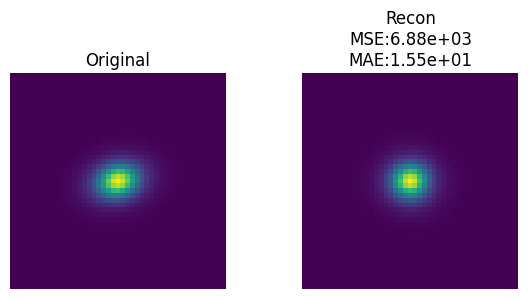


EPOCH 25/30
Train Loss: 8.733e-05 | MSE: 5.625e-05 | KL: 3.108e-02
Val   Loss: 8.876e-05 | MSE: 5.769e-05 | KL: 3.107e-02


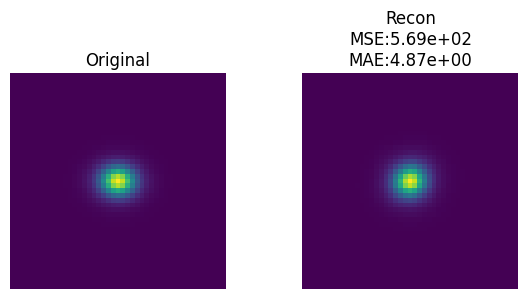

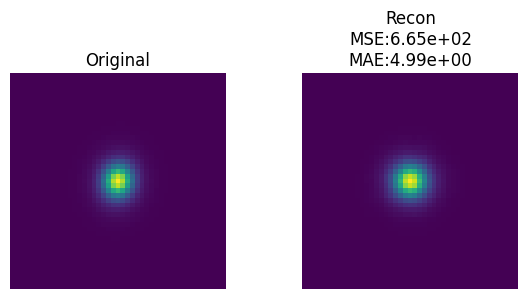

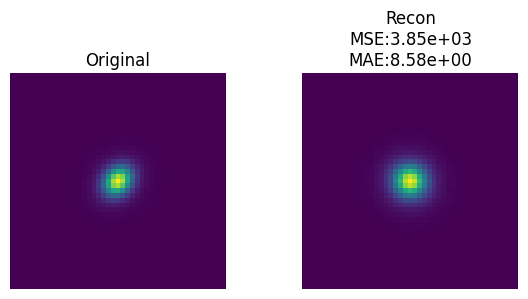


EPOCH 26/30
Train Loss: 8.689e-05 | MSE: 5.551e-05 | KL: 3.138e-02
Val   Loss: 8.541e-05 | MSE: 5.333e-05 | KL: 3.209e-02


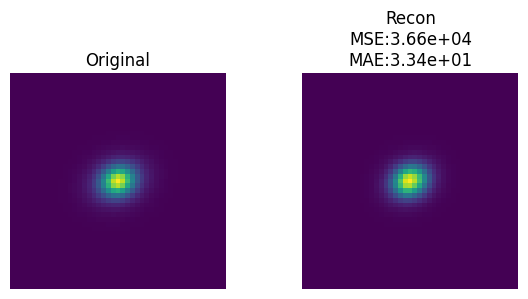

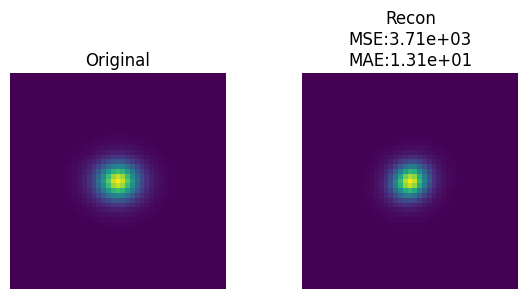

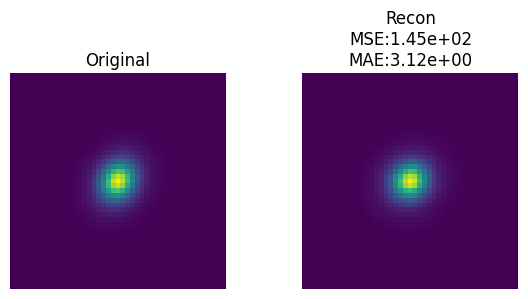


EPOCH 27/30
Train Loss: 8.651e-05 | MSE: 5.489e-05 | KL: 3.161e-02
Val   Loss: 8.521e-05 | MSE: 5.385e-05 | KL: 3.135e-02


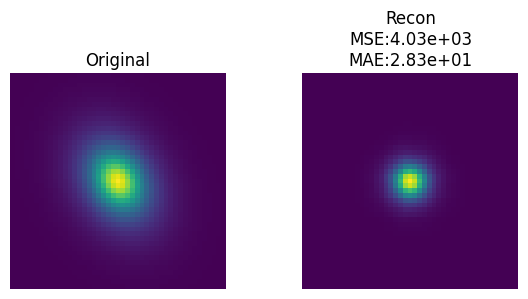

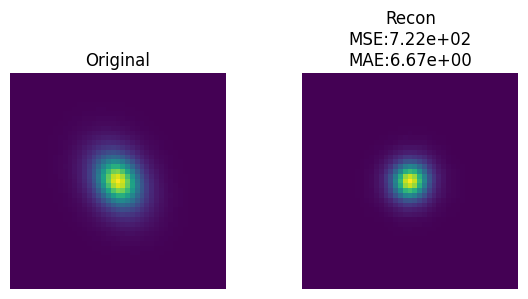

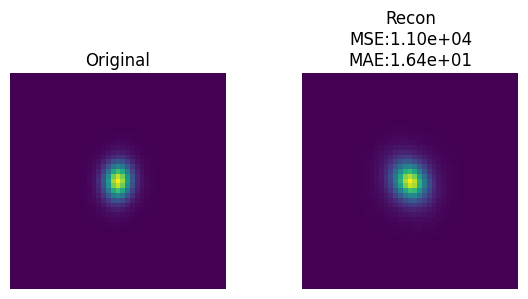


EPOCH 28/30
Train Loss: 8.629e-05 | MSE: 5.455e-05 | KL: 3.174e-02
Val   Loss: 8.496e-05 | MSE: 5.374e-05 | KL: 3.122e-02


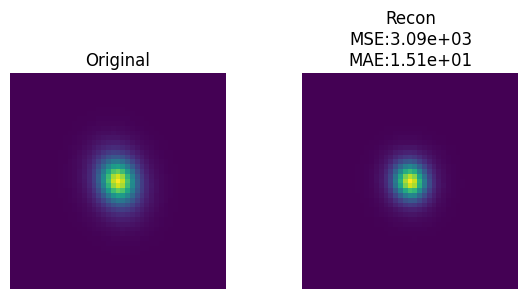

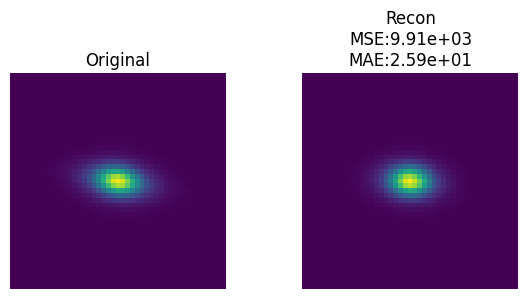

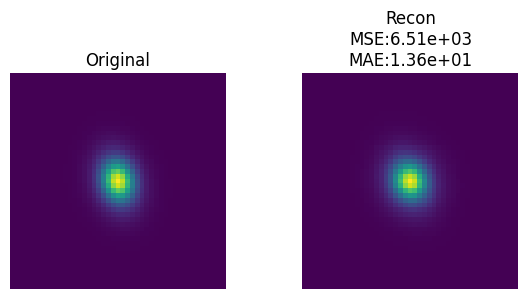


EPOCH 29/30
Train Loss: 8.617e-05 | MSE: 5.437e-05 | KL: 3.180e-02
Val   Loss: 8.590e-05 | MSE: 5.470e-05 | KL: 3.121e-02


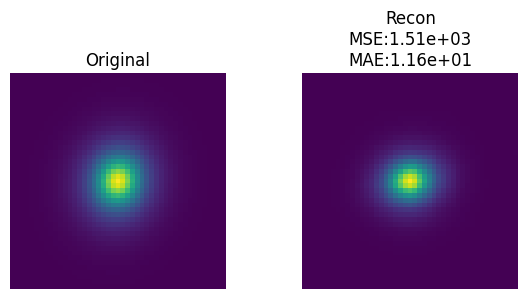

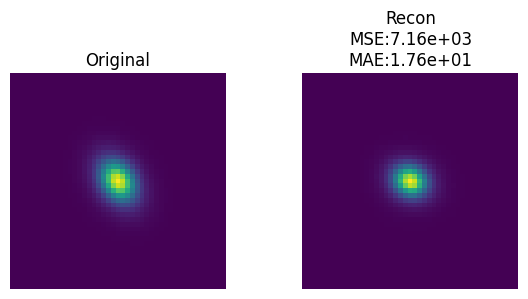

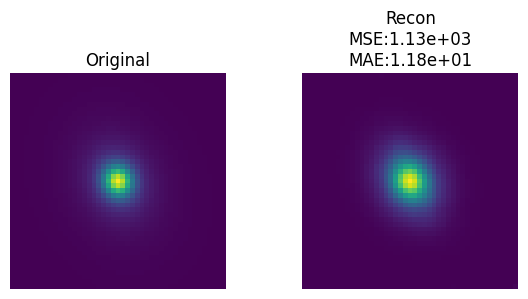


EPOCH 30/30
Train Loss: 8.583e-05 | MSE: 5.388e-05 | KL: 3.195e-02
Val   Loss: 8.476e-05 | MSE: 5.328e-05 | KL: 3.148e-02
Checkpoint saved at epoch 30


In [33]:
# --- Training Loop ---
num_epochs = 30
train_loss = np.empty(num_epochs)
val_loss = np.empty(num_epochs)
train_mse = np.empty(num_epochs)
val_mse = np.empty(num_epochs)
train_kl = np.empty(num_epochs)
val_kl = np.empty(num_epochs)

# Reset checkpoint file
checkpoint_path = "vae_checkpoint.pth"
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

for epoch in range(num_epochs):
    train_loss[epoch], train_mse[epoch], train_kl[epoch] = train_epoch(vae, device, train_loader, optimizer)
    val_loss[epoch], val_mse[epoch], val_kl[epoch] = test_epoch(vae, device, val_loader)

    print(f"\nEPOCH {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss[epoch]:.3e} | MSE: {train_mse[epoch]:.3e} | KL: {train_kl[epoch]:.3e}")
    print(f"Val   Loss: {val_loss[epoch]:.3e} | MSE: {val_mse[epoch]:.3e} | KL: {val_kl[epoch]:.3e}")

    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch, vae, optimizer,
                        train_loss[:epoch + 1], train_mse[:epoch + 1], train_kl[:epoch + 1],
                        val_loss[:epoch + 1], val_mse[:epoch + 1], val_kl[:epoch + 1])


#### Continue the training from checkpoints

In [ ]:
# --- Load checkpoint ---
checkpoint_path = "../scripts/checkpoints/vae_checkpoint.pth"
start_epoch, train_loss_old, train_mse_old, train_kl_old, val_loss_old, val_mse_old, val_kl_old = load_checkpoint(vae, optimizer, checkpoint_path)

# Create full arrays
train_loss = np.empty(num_epochs)
val_loss = np.empty(num_epochs)
train_mse = np.empty(num_epochs)
val_mse = np.empty(num_epochs)
train_kl = np.empty(num_epochs)
val_kl = np.empty(num_epochs)

# Copy old values into arrays
train_loss[:start_epoch + 1] = train_loss_old
val_loss[:start_epoch + 1] = val_loss_old
train_mse[:start_epoch + 1] = train_mse_old
val_mse[:start_epoch + 1] = val_mse_old
train_kl[:start_epoch + 1] = train_kl_old
val_kl[:start_epoch + 1] = val_kl_old

# Reset new checkpoint path
checkpoint_path = "vae_checkpoint_cont.pth"

# --- Continue training ---
for epoch in range(start_epoch + 1, num_epochs):
    train_loss[epoch], train_mse[epoch], train_kl[epoch] = train_epoch(vae, device, train_loader, optimizer)
    val_loss[epoch], val_mse[epoch], val_kl[epoch] = test_epoch(vae, device, val_loader)

    print(f"\nEPOCH {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss[epoch]:.3e} | MSE: {train_mse[epoch]:.3e} | KL: {train_kl[epoch]:.3e}")
    print(f"Val   Loss: {val_loss[epoch]:.3e} | MSE: {val_mse[epoch]:.3e} | KL: {val_kl[epoch]:.3e}")

    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch, vae, optimizer,
                        train_loss[:epoch + 1], train_mse[:epoch + 1], train_kl[:epoch + 1],
                        val_loss[:epoch + 1], val_mse[:epoch + 1], val_kl[:epoch + 1], checkpoint_path)

### Evaluation: loss function, reconstruction images

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vae = VAE(latent_dim=32).to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)
checkpoint_path = "vae_checkpoint.pth"

epoch, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl = load_checkpoint(vae, optimizer, checkpoint_path)

Checkpoint loaded from epoch 30


In [12]:
def plot_loss_function(num_epochs, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl):
  fig, ax = plt.subplots(figsize=(8, 6), sharex=True)

  epochs = np.arange(1, num_epochs + 1)

  # Train Loss Plot
  ax.plot(epochs, train_loss, label="Train Loss", color="royalblue", linestyle="-")
  ax.plot(epochs, val_loss, label="Validation Loss", color="crimson", linestyle="-")

  ax.plot(epochs, train_mse, label="Train MSE", color="cyan", linestyle="--")
  ax.plot(epochs, val_mse, label="Val MSE", color="orange", linestyle="--")

  ax.plot(epochs, train_kl, label="Train KL", color="limegreen", linestyle="--")
  ax.plot(epochs, val_kl, label="Val KL", color="gold", linestyle="--")

  ax.set_xlabel("Epochs", fontsize=11)
  ax.set_ylabel("Loss", fontsize=11)
  ax.set_yscale("log")  # Set log scale
  ax.grid(True, linestyle="--", alpha=0.6)
  ax.legend()

  # Validation Loss Plot
  plt.tight_layout()
  plt.show()

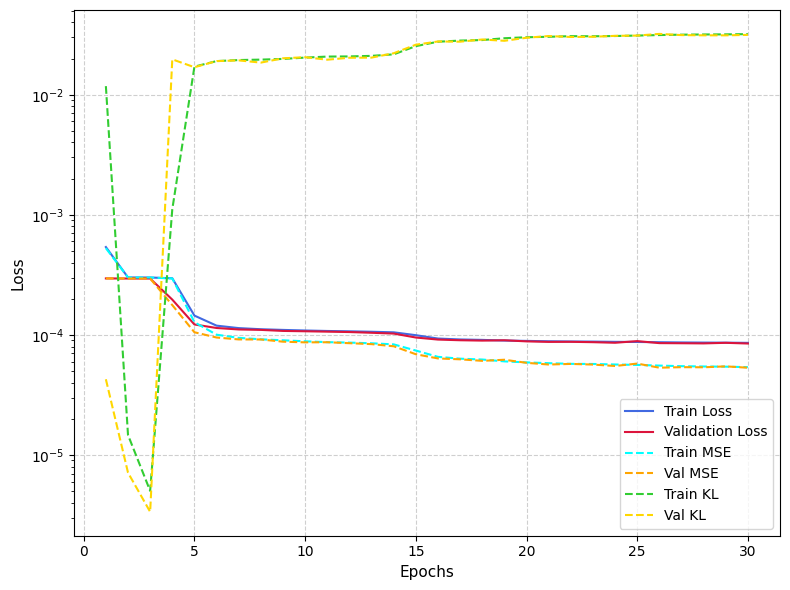

In [13]:
num_epochs = epoch + 1
plot_loss_function(num_epochs, train_loss, train_mse, train_kl, val_loss, val_mse, val_kl)

In [18]:
def show_random_reconstructions(vae, dataset, device, avg_max_vals, n_samples=5):

    vae.eval()
    fig, axs = plt.subplots(n_samples, 3, figsize=(6, 3 * n_samples))
    
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset))
        img = dataset[idx][0].unsqueeze(0).to(device)  # shape [1, 1, 45, 45]
        with torch.no_grad():
            recon, mu, log_var = vae(img)

        img_ = denormalize_non_linear(img.squeeze().cpu().numpy(), avg_max_vals)
        recon_ = denormalize_non_linear(recon.squeeze().cpu().numpy(), avg_max_vals)

        band = 2
        # mse = ((recon_[band] - img_[band]) ** 2).mean().item()
        # mae = (np.abs(recon_[band] - img_[band])).mean().item()
        
        accuracy = (((recon_[band] - img_[band]) / img_[band])**2).mean().item
        axs[i, 0].imshow(img_[band], cmap='viridis')
        axs[i, 0].set_title(f"Original (idx {idx})")
        axs[i, 1].imshow(recon_[band], cmap='viridis')
        axs[i, 1].set_title(f"Reconstruction")
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

        im2 = axs[i, 2].imshow(img_[band] - recon_[band])
        axs[i, 2].set_title(f"Residual")
        axs[i, 2].axis('off')

        # fig.colorbar(im2, ax=axs[i, 2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

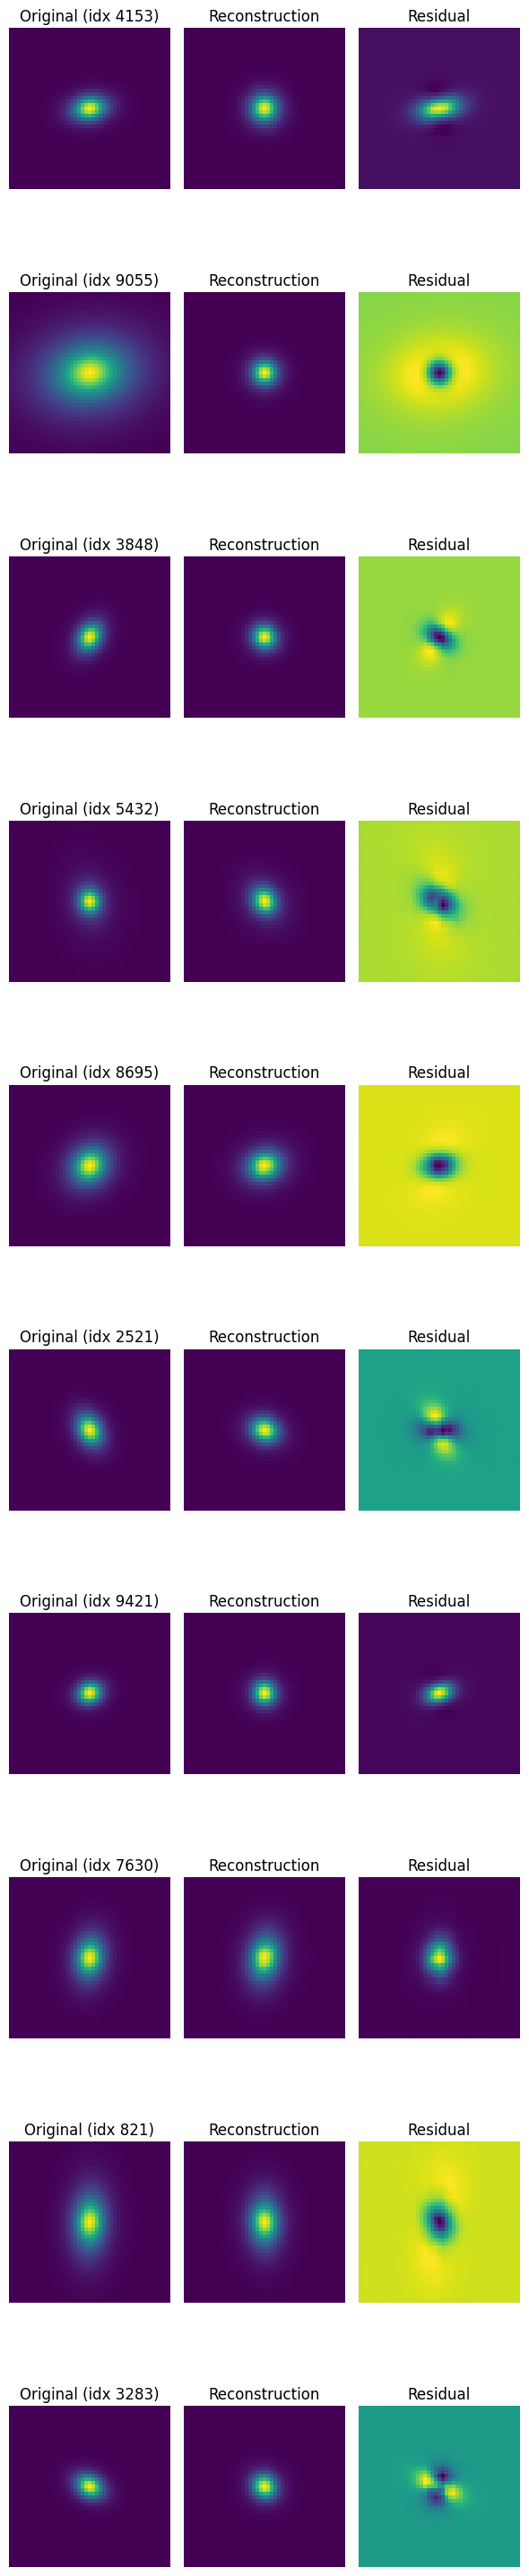

In [28]:
show_random_reconstructions(vae, val_dataset, device, dataset.avg_max_vals, n_samples=10)

In [24]:
from skimage.metrics import structural_similarity as ssim

def calculate_average_ssim(vae, dataset, device, n_samples=1000):
    vae.eval()

    # Prepare list to store SSIM values for each sample
    ssim_values = []

    # Calculate SSIM for each sample
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset)) 
        img = dataset[idx][0].unsqueeze(0).to(device)  # Input image
        img_ = img.squeeze().cpu().numpy()  # Convert to numpy (original image)
        
        # Get the reconstructed image
        with torch.no_grad():
            reconstructed_img, _, _ = vae(img)  # Assuming this is how you get the reconstruction
        recon_ = reconstructed_img.squeeze().cpu().numpy()  # Convert to numpy (reconstructed image)
        
        # Calculate SSIM between original and reconstructed images
        # SSIM expects 2D or 3D images (height, width, channels), so you may need to reshape or handle channels if necessary
        ssim_value = ssim(img_[0], recon_[0], data_range=img_[0].max() - img_[0].min())  # for grayscale image
        ssim_values.append(ssim_value)

    # Calculate the average SSIM over the sample
    average_ssim = np.mean(ssim_values)
    print(f"Average SSIM over {n_samples} samples: {average_ssim}")

    return average_ssim

In [26]:
ssim_ = calculate_average_ssim(vae, val_dataset, device, n_samples=1000)

Average SSIM over 1000 samples: 0.9096292458012132


### Latent space

#### Random reconstruction from 32-D latent space

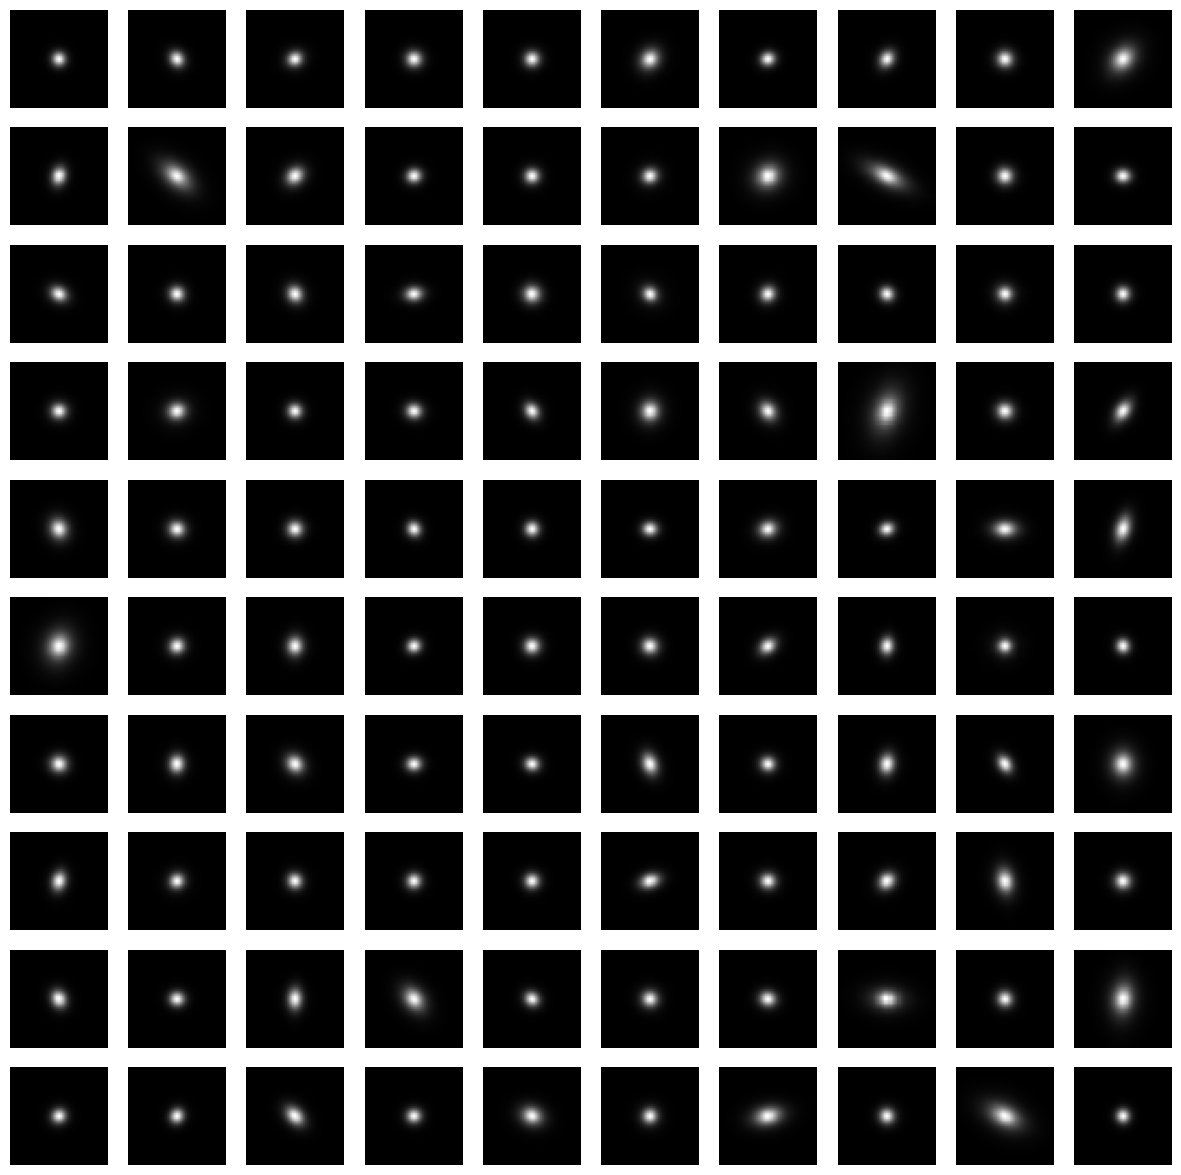

In [43]:
num_samples = 100
latent_samples = torch.randn(num_samples, 32)
device = next(vae.parameters()).device
latent_samples = latent_samples.to(device)

# Decode to get images
with torch.no_grad():
    generated_images = vae.decoder(latent_samples).cpu()

# Plot the generated images
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        k = 10*i + j
        denorm = denormalize_non_linear(generated_images[k].squeeze(), dataset.avg_max_vals)
        axes[i,j].imshow(denorm[2], cmap="gray")
        # axes[i,j].imshow(generated_images[k, 2], cmap="gray")
        axes[i,j].axis("off")
plt.show()

#### Dimension reduction

In [45]:
from sklearn.decomposition import PCA

In [77]:
def tsne_latent_space(vae, dataset, device, n_samples=1000):
    vae.eval()

    # Prepare lists to store latent vectors and corresponding labels
    latent_vectors = []
    labels = []

    # Extract latent vectors and labels
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset)) 
        img = dataset[idx][0].unsqueeze(0).to(device) 
        z, e1, e2, _ = dataset[idx][1]  
        e = np.sqrt(e1**2 + e2**2)

        with torch.no_grad():
            _, mu, _ = vae(img)  

        # Store the latent vectors and corresponding labels
        latent_vectors.append(mu.squeeze().cpu().numpy())  # Convert to numpy and remove extra dimensions
        labels.append(e1)

    # Convert lists to numpy arrays for t-SNE
    latent_vectors = np.array(latent_vectors)
    labels = np.array(labels)

    # Apply t-SNE to reduce the dimensionality of the latent space to 2D
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Scatter plot of the latent space, color-coded by the labels
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Labels')
    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

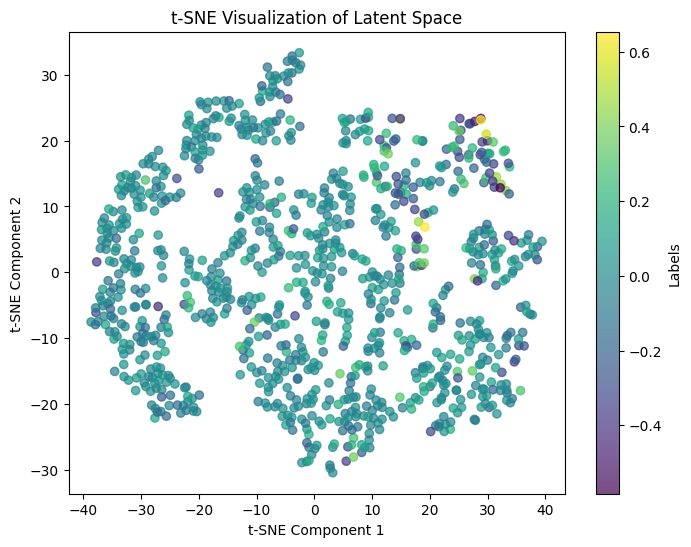

In [78]:
tsne_latent_space(vae, dataset, device, n_samples=1000)

##### 3d

In [79]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
def tsne_latent_space(vae, dataset, device, n_samples=1000):
    vae.eval()

    # Prepare lists to store latent vectors and corresponding labels
    latent_vectors = []
    labels_e1 = []
    labels_e2 = []

    # Extract latent vectors and labels
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset)) 
        img = dataset[idx][0].unsqueeze(0).to(device) 
        z, e1, e2, _ = dataset[idx][1]  

        with torch.no_grad():
            _, mu, _ = vae(img)  

        # Store the latent vectors and corresponding labels
        latent_vectors.append(mu.squeeze().cpu().numpy())  # Convert to numpy and remove extra dimensions
        labels_e1.append(e1)
        labels_e2.append(e2)

    # Convert lists to numpy arrays for t-SNE
    latent_vectors = np.array(latent_vectors)
    labels_e1 = np.array(labels_e1)
    labels_e2 = np.array(labels_e2)

    # Combine e1 and e2 into a single value for the color (e.g., magnitude of the ellipticity)
    e = np.sqrt(labels_e1**2 + labels_e2**2)

    # Apply t-SNE to reduce the dimensionality of the latent space to 3D
    tsne = TSNE(n_components=3, random_state=42)
    latent_3d = tsne.fit_transform(latent_vectors)

    # Scatter plot of the latent space, color-coded by the combined magnitude of e1 and e2
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=e, cmap='viridis', alpha=0.7)

    # Add color bar for the ellipticity magnitude
    colorbar = plt.colorbar(scatter, ax=ax)
    colorbar.set_label('E')

    ax.set_title('t-SNE 3D Visualization of Latent Space')
    ax.set_xlabel('t-SNE Component 1')
    ax.set_ylabel('t-SNE Component 2')
    ax.set_zlabel('t-SNE Component 3')

    plt.show()

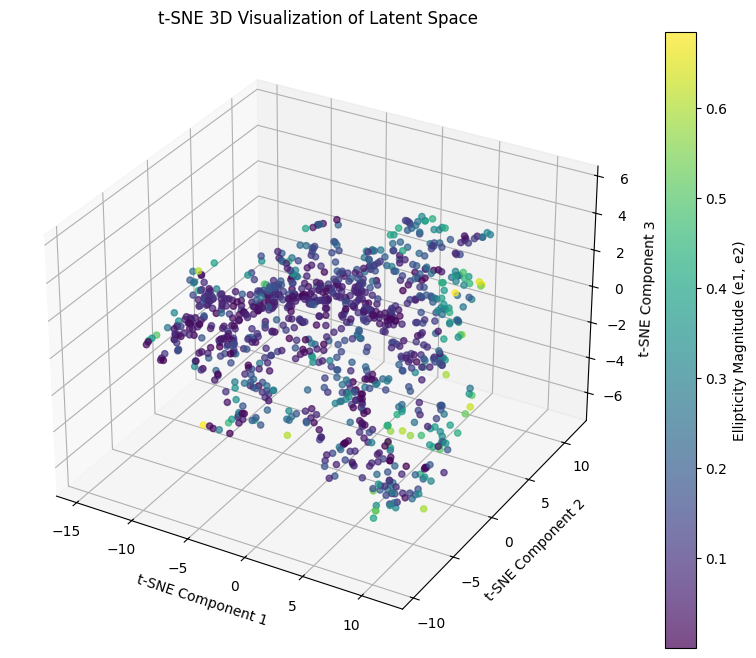

In [84]:
tsne_latent_space(vae, dataset, device, n_samples=1000)

##### U-map

In [85]:
def umap_latent_space(vae, dataset, device, n_samples=1000):
    vae.eval()

    # Prepare lists to store latent vectors and corresponding labels
    latent_vectors = []
    labels_e1 = []
    labels_e2 = []

    # Extract latent vectors and labels
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset)) 
        img = dataset[idx][0].unsqueeze(0).to(device) 
        z, e1, e2, _ = dataset[idx][1]  

        with torch.no_grad():
            _, mu, _ = vae(img)  

        # Store the latent vectors and corresponding labels
        latent_vectors.append(mu.squeeze().cpu().numpy())  # Convert to numpy and remove extra dimensions
        labels_e1.append(e1)
        labels_e2.append(e2)

    # Convert lists to numpy arrays for UMAP
    latent_vectors = np.array(latent_vectors)
    labels_e1 = np.array(labels_e1)
    labels_e2 = np.array(labels_e2)

    # Combine e1 and e2 into a single value for the color (e.g., magnitude of the ellipticity)
    e = np.sqrt(labels_e1**2 + labels_e2**2)

    # Apply UMAP to reduce the dimensionality of the latent space to 3D
    umap_model = umap.UMAP(n_components=3, random_state=42)
    latent_3d = umap_model.fit_transform(latent_vectors)

    # Scatter plot of the latent space, color-coded by the combined magnitude of e1 and e2
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=e, cmap='viridis', alpha=0.7)

    # Add color bar for the ellipticity magnitude
    colorbar = plt.colorbar(scatter, ax=ax)
    colorbar.set_label('E')

    ax.set_title('UMAP 3D Visualization of Latent Space')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.set_zlabel('UMAP Component 3')

    plt.show()

In [86]:
umap_latent_space(vae, dataset, device, n_samples=1000)

NameError: name 'umap' is not defined

##### Random representation from latent space

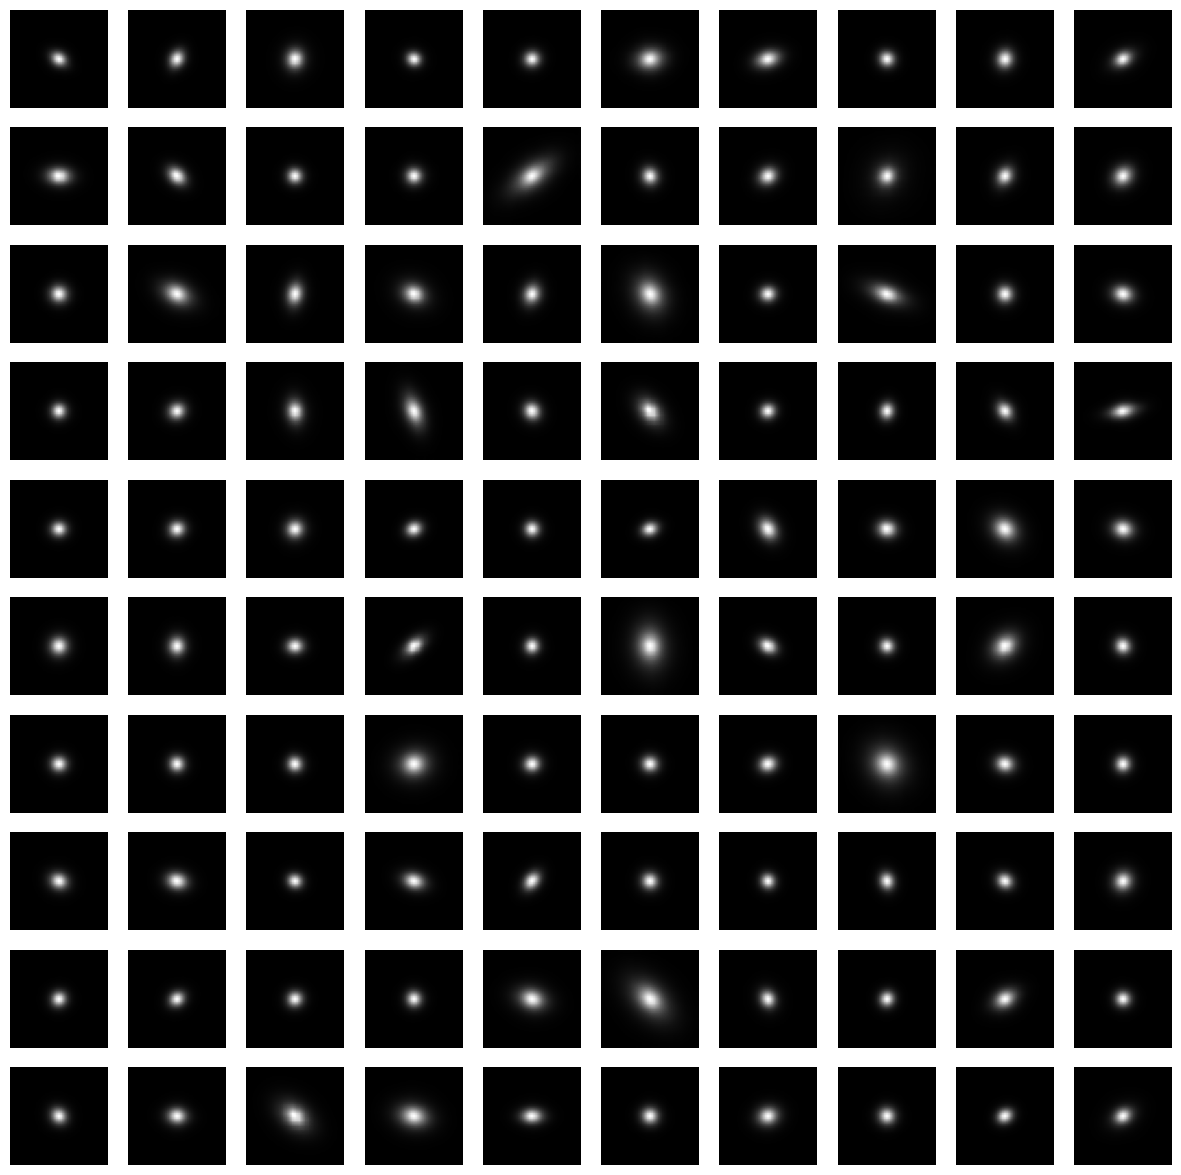

In [48]:
# Plot the generated images on a 2D grid corresponding to the PCA reduced latent space
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        k = 10 * i + j
        # Denormalize the generated images
        denorm = denormalize_non_linear(generated_images[k].squeeze(), dataset.avg_max_vals)
        
        # Scatter plot for each image on the PCA reduced 2D latent space
        axes[i, j].imshow(denorm[2], cmap="gray")
        axes[i, j].axis("off")
        
        # You can use the reduced latent space coordinates to color the grid, etc.
        # axes[i, j].set_title(f"PCA: {latent_samples_2d[k]}") # Example title to show PCA coordinates

plt.show()

-----

## Regressor

In [67]:
class LatentRegressor(nn.Module):
    def __init__(self, latent_dim, output_dim=3):  # output_dim = redshift, e1, e2
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )

    def forward(self, z):
        return self.net(z)

In [85]:
def train_epoch_reg(vae, device, dataloader, optimizer):
    vae.encoder.eval() # Freeze VAE
    for param in vae.encoder.parameters():
        param.requires_grad = False

    regressor.train()

    train_loss = 0.0
    for x, target in dataloader:
        x, target = x.to(device), target[:, :3].to(device)

        with torch.no_grad():
            mu, _ = vae.encoder(x)

        pred = regressor(mu)
        loss = F.mse_loss(pred, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    n = len(dataloader.dataset)
    return train_loss / n

def val_epoch_reg(vae, device, dataloader):
    vae.encoder.eval()
    for param in vae.encoder.parameters():
        param.requires_grad = False

    regressor.eval()
    
    val_loss = 0.0
    with torch.no_grad():
        for x, target in dataloader:
            x, target = x.to(device), target[:, :3].to(device)

            mu, _ = vae.encoder(x)

            pred = regressor(mu)

            loss = F.mse_loss(pred, target)

            val_loss += loss.item()
    n = len(dataloader.dataset)
    return val_loss / n

In [1]:
regressor = LatentRegressor(latent_dim=32).to(device)
optimizer = torch.optim.Adam(regressor.parameters(), lr=1e-3)

# --- Training Loop ---
num_epochs = 30
train_loss = np.empty(num_epochs)
val_loss = np.empty(num_epochs)
train_mse = np.empty(num_epochs)
val_mse = np.empty(num_epochs)
train_kl = np.empty(num_epochs)
val_kl = np.empty(num_epochs)

# Reset checkpoint file
checkpoint_path = "vae_checkpoint_regressor.pth"
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)

for epoch in range(num_epochs):
    train_loss[epoch] = train_epoch_reg(vae, device, train_loader, optimizer)
    val_loss[epoch] = val_epoch_reg(vae, device, val_loader)

    print(f"\nEPOCH {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss[epoch]:.3e}")
    print(f"Val   Loss: {val_loss[epoch]:.3e}")

    if (epoch + 1) % 10 == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch, vae, optimizer,
                        train_loss[:epoch + 1], train_mse[:epoch + 1], train_kl[:epoch + 1],
                        val_loss[:epoch + 1], val_mse[:epoch + 1], val_kl[:epoch + 1], checkpoint_path=checkpoint_path)

NameError: name 'LatentRegressor' is not defined

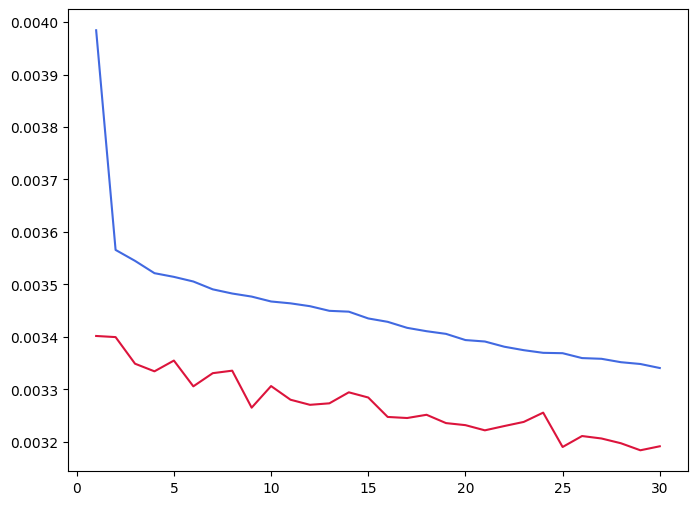

In [87]:
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)

epochs = np.arange(1, num_epochs + 1)

# Train Loss Plot
ax.plot(epochs, train_loss, label="Train Loss", color="royalblue", linestyle="-")
ax.plot(epochs, val_loss, label="Validation Loss", color="crimson", linestyle="-")

In [ ]:
def show_random_reconstructions(vae, dataset, device, avg_max_vals, n_samples=5):

    vae.eval()
    regressor.eval()

    fig, axs = plt.subplots(n_samples, 3, figsize=(6, 3 * n_samples))
    
    for i in range(n_samples):
        idx = np.random.randint(0, len(dataset))
        img = dataset[idx][0].unsqueeze(0).to(device)  # shape [1, 1, 45, 45]
        redshift, e1, 
        with torch.no_grad():
            recon, mu, log_var = vae(img)

        pred_redshift, pred_e1, pred_e2 = regressor(mu)
        #recon_ = log_denorm(recon.squeeze().cpu().numpy(), mu=1.0, nu=2.5)
        img_ = denormalize_non_linear(img.squeeze().cpu().numpy(), avg_max_vals)
        recon_ = denormalize_non_linear(recon.squeeze().cpu().numpy(), avg_max_vals)
        #img_ = (img.squeeze().cpu().numpy())
        band = 2
        mse = ((recon_[band] - img_[band]) ** 2).mean().item()
        mae = (np.abs(recon_[band] - img_[band])).mean().item()

        axs[i, 0].imshow(img_[band], cmap='viridis')
        axs[i, 0].set_title(f"Original (idx {idx})")
        axs[i, 1].imshow(recon_[band], cmap='viridis')
        axs[i, 1].set_title(f"Reconstruction")
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

        im2 = axs[i, 2].imshow(img_[band] - recon_[band])
        axs[i, 2].set_title(f"Residual")
        axs[i, 2].axis('off')

        # fig.colorbar(im2, ax=axs[i, 2], fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

---

# TESTING STUFF 

In [ ]:
plt.hist(img_.flatten(), bins=500)

plt.xlabel("flux value")
plt.ylabel("frequency")
plt.xscale("log")
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(img_.flatten(), bins=50)

### VAE model

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6), sharex=True)

epochs = np.arange(1, num_epochs + 1)

# Train Loss Plot
ax.plot(epochs, train_loss, label="Train Loss", color="royalblue", linestyle="-")
ax.plot(epochs, val_loss, label="Validation Loss", color="crimson", linestyle="-")

ax.plot(epochs, train_mse, label="Train MSE", color="cyan", linestyle="--")
ax.plot(epochs, val_mse, label="Val MSE", color="orange", linestyle="--")

# ax.plot(epochs, train_kl, label="Train KL", color="limegreen", linestyle="--")
# ax.plot(epochs, val_kl, label="Val KL", color="gold", linestyle="--")

ax.set_xlabel("Epochs", fontsize=11)
ax.set_ylabel("Loss", fontsize=11)
ax.set_yscale("log")  # Set log scale
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend()

# Validation Loss Plot
plt.tight_layout()
plt.show()

In [ ]:
img = val_dataset.dataset[4][0]
img = img.unsqueeze(0)
img = img.to(device)

In [ ]:
vae = vae.to(device)

In [ ]:
img = val_dataset.dataset[4][0]
img = img.unsqueeze(0)
img = img.to(device)

with torch.no_grad():
    mu, logvar = vae.encoder(img)
    print(f'{mu.device}')
    z, kl = reparameterization(mu, logvar)

    recon = vae.decoder(z)

In [ ]:
num_samples = 100
latent_samples = torch.randn(num_samples, 32)  # Sample random points from N(0,1)
device = next(vae.parameters()).device
latent_samples = latent_samples.to(device)

# Decode to get images
with torch.no_grad():
    generated_images = vae.decoder(latent_samples).cpu()

# Plot the generated images
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        k = 10*i + j
        axes[i,j].imshow(generated_images[k].squeeze(), cmap="gray")
        axes[i,j].axis("off")
plt.show()

In [ ]:
def training_loop(num_epochs, epoch_cp, train_loss_cp, train_mse_cp, train_kl_cp, val_loss_cp, val_mse_cp, val_kl_cp, checkpoint=False, model=None):
    if checkpoint:
        checkpoint = torch.load(model, weights_only=False)
        
    train_loss = np.empty(num_epochs)
    val_loss = np.empty(num_epochs)
    train_mse = np.empty(num_epochs)
    val_mse = np.empty(num_epochs)
    train_kl = np.empty(num_epochs)
    val_kl = np.empty(num_epochs)
    
    train_loss[:epoch_cp + 1] = train_loss_cp
    train_mse[:epoch_cp + 1] = train_mse_cp
    train_kl[:epoch_cp + 1] = train_kl_cp

    val_loss[:epoch_cp + 1] = val_loss_cp
    val_mse[:epoch_cp + 1] = val_mse_cp
    val_kl[:epoch_cp + 1] = val_kl_cp

    for epoch in range(epoch_cp, num_epochs):
        train_loss[epoch], train_mse[epoch], train_kl[epoch] = train_epoch(vae, device, train_loader, optimizer)
        val_loss[epoch], val_mse[epoch], val_kl[epoch] = test_epoch(vae, device, val_loader)
        print('\n EPOCH {}/{} \n train loss {:.3e} \t mse {:.3e} \t kl {:.3e} \n val loss {:.3e} \t mse {:.3e} \t kl {:.3e}'.format(epoch + 1, num_epochs, train_loss[epoch], train_mse[epoch], train_kl[epoch], val_loss[epoch], val_mse[epoch], val_kl[epoch]))
        ## Save checkpoint every 20 epochs
        if (epoch + 1) % 10 == 0:
            save_checkpoint(epoch, vae, optimizer, train_loss[:epoch+1], train_mse[:epoch+1], train_kl[:epoch+1], val_loss[:epoch+1], val_mse[:epoch+1], val_kl[:epoch+1])

## Model

In [ ]:
# Load the checkpoint
checkpoint = torch.load("vae_checkpoint_1.pth", weights_only=False)

In [ ]:
train_loss = checkpoint["train_loss"]
val_loss = checkpoint["val_loss"]
num_epochs = len(train_loss)

In [ ]:
def plot_loss_function(num_epochs, train_loss, val_loss):
    fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

    epochs = np.arange(1, num_epochs + 1)

    # Train Loss Plot
    ax[0].plot(epochs, train_loss, label="Train Loss", color="royalblue", linestyle="-", marker="o", markersize=1)
    ax[0].set_title("Training Loss", fontsize=12, fontweight="bold")
    ax[0].set_ylabel("Loss", fontsize=11)
    # ax[0].set_xscale("log")  # Set log scale
    ax[0].grid(True, linestyle="--", alpha=0.6)
    ax[0].legend()

    # Validation Loss Plot
    ax[1].plot(epochs, val_loss, label="Validation Loss", color="crimson", linestyle="-", marker="s", markersize=1)
    ax[1].set_title("Validation Loss", fontsize=12, fontweight="bold")
    ax[1].set_xlabel("Epochs", fontsize=11)
    ax[1].set_ylabel("Loss", fontsize=11)
    # ax[1].set_xscale("log")  # Set log scale
    ax[1].grid(True, linestyle="--", alpha=0.6)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
plot_loss_function(num_epochs, train_loss, val_loss)

In [ ]:
vae = VAE(latent_dims=32)
vae.load_state_dict(checkpoint['model_state_dict'])
vae.eval()

def generated_images():
    num_samples = 100

    latent_samples = torch.randn(num_samples, 32)  # Sample random points from N(0,1)

    # Get the device of the model
    device = next(vae.parameters()).device

    # Move latent samples to the same device as the model
    latent_samples = latent_samples.to(device)

    # Decode to get images
    with torch.no_grad():
        generated_images = vae.decoder(latent_samples)

    # Plot the generated images
    fig, axes = plt.subplots(10, 10, figsize=(15, 15))
    for i in range(10):
        for j in range(10):
            k = 10*i + j
            axes[i,j].imshow(generated_images[k].squeeze(), cmap="gray")
            axes[i,j].axis("off")
    plt.show()

In [ ]:
generated_images()